In [1]:
import pandas as pd
from pandas import DataFrame
import matplotlib.pyplot as plt
import matplotlib.axes as axe
import matplotlib
import seaborn as sns
import scipy.stats as stats
import numpy as np
import re
import nltk
import math

In [2]:
columns = ['year', 'month', 'title', 'abstract', 'first_author', 'journal_name', 'journal_abb', 'language']
df_2014 =pd.read_csv('C:/Users/Esme/Desktop/Springboard/Data_Scrapper/Cancer_results_2014_Jan_test.tab', index_col = 0, header= 0, sep="\t", engine = 'python', na_filter = False, parse_dates = columns)
df_2015=pd.read_csv('C:/Users/Esme/Desktop/Springboard/Data_Scrapper/Cancer_results_2015.tab', index_col = 0, header= 0, sep="\t", engine = 'python', na_filter = False, parse_dates = columns)
df_2016=pd.read_csv('C:/Users/Esme/Desktop/Springboard/Data_Scrapper/Cancer_results_2016_1.tab', index_col = 0, header= 0, sep="\t", engine = 'python', na_filter = False, parse_dates = columns)
df_2013=pd.read_csv('C:/Users/Esme/Desktop/Springboard/Data_Scrapper/Cancer_results_2013.tab', index_col = 0, header= 0, sep="\t", engine = 'python', na_filter = False, parse_dates = columns)
df_2012=pd.read_csv('C:/Users/Esme/Desktop/Springboard/Data_Scrapper/Cancer_results_2012.tab', index_col = 0, header= 0, sep="\t", engine = 'python', na_filter = False, parse_dates = columns)

In [3]:
# function to clean up and wrangle initial data
def clean_pubmed_df(input_df):
    # setting an editing list of each DF to work with
    # clean up the year, and save as an intiger in each DF
    input_df = input_df.copy()
    input_df['year']= input_df['year'].astype(str).str[:4].astype(int)
    # set columns labels 
    columns_names = [ 'Year', 'Month', 'Paper Title', 'Abstract', 'First Author Name', 'Journal Name', 'Journal Abb.', 'Language']
    input_df.columns = columns_names
    # clean up language listing to be uniform
    input_df['Language']= input_df['Language'].astype(str).str[2:5]
    input_df['Abstract']= input_df['Abstract'].astype(str).replace(('[', ']', 'StringElement', '(', ')', "'"),' ')
    input_df['Abstract']= input_df['Abstract'].map(lambda x: x.lstrip('(){}[] StringElement').
                                                   rstrip('(){}[] StringElement'))
    input_df['First Author Name']= input_df['First Author Name'].map(lambda x: x.lstrip('(){}[] ').rstrip('() [] {}'))
    input_df['Journal Name']= input_df['Journal Name'].str.lower()
    return input_df

In [4]:
df_2014_edited = clean_pubmed_df(df_2014)
df_2015_edited = clean_pubmed_df(df_2015)
df_2016_edited = clean_pubmed_df(df_2016)
df_2013_edited = clean_pubmed_df(df_2013)
df_2012_edited = clean_pubmed_df(df_2012)

In [5]:
df_2012_2013 = df_2012_edited.append(df_2013_edited)
df_2012_2013_2014 = df_2012_2013.append(df_2014_edited)
df_2012_2013_2014_2015 = df_2012_2013_2014.append(df_2015_edited)
df_all = df_2012_2013_2014_2015.append(df_2016_edited)
df_all.head(3)

,Year,Month,Paper Title,Abstract,First Author Name,Journal Name,Journal Abb.,Language
id,,,,,,,,
28473730,2012,6,MODELING DEPENDENT GENE EXPRESSION.,'In this paper we propose a Bayesian approach ...,"'Telesca', 'Donatello'",annals of statistics,Ann Stat,eng
27085860,2016,5,Novel luminescent silica nanoparticles (LSN): ...,'Mutations in the p53 tumor suppressor gene ar...,"'Rejeeth', 'Chandrababu'",the journal of pharmacy and pharmacology,J. Pharm. Pharmacol.,eng
26729999,2015,12,Preoperative Nutritional Assessment in Elderly...,'This study aims to evaluate and compare the u...,"'Dubhashi', 'S P'",the indian journal of surgery,Indian J Surg,eng


In [6]:
df_all.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21685 entries, 28473730 to 28040198
Data columns (total 8 columns):
Year                 21685 non-null int32
Month                21685 non-null int64
Paper Title          21685 non-null object
Abstract             21685 non-null object
First Author Name    21685 non-null object
Journal Name         21685 non-null object
Journal Abb.         21685 non-null object
Language             21685 non-null object
dtypes: int32(1), int64(1), object(6)
memory usage: 1.4+ MB


# Goal now:
find a trend and something of meaning to state and/or prediction model in Pubmed


# Question Now:
Are there points of human bias if what papers are published in high IFJ? Can we identify social trends in those papers over time?

# Measuring:
TFIDF of papers isolated by 1) high impact journals, medium impact journals and low (not measured) impact journals
for each year, against each other and/or against all years

upload IFJ scores by journal from source, uploaded full list for 2017. 
 add column to exisitng DF about those
IFJ scores from : http://www.scimagojr.com/journalrank.php

In [7]:
df_IFJ =pd.read_csv('C:/Users/Esme/Desktop/SpringBoard/Capstone_1/JournalImpactfactor_2017.csv', header= 0, sep=",", engine = 'python', na_filter = False)
df_IFJ.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12094 entries, 0 to 12093
Data columns (total 9 columns):
ï»¿Rank                  12094 non-null object
Full Journal Title       12094 non-null object
Total Cites              12094 non-null object
Journal Impact Factor    12094 non-null object
Eigenfactor Score        12094 non-null object
Unnamed: 5               12094 non-null object
Unnamed: 6               12094 non-null object
Unnamed: 7               12094 non-null object
Unnamed: 8               12094 non-null object
dtypes: object(9)
memory usage: 850.4+ KB


In [8]:
# Clean up extra columns
df_IFJ= df_IFJ.drop('Unnamed: 5', axis= 1)
df_IFJ= df_IFJ.drop('Unnamed: 6', axis= 1)
df_IFJ= df_IFJ.drop('Unnamed: 7', axis= 1)
df_IFJ= df_IFJ.drop('Unnamed: 8', axis= 1)

In [9]:
# cleaning up DF NaN values, by setting NAN score to 0 for ease of sorting later
df_IFJ.fillna(0)
df_IFJ.replace('Not Available', 0)

,ï»¿Rank,Full Journal Title,Total Cites,Journal Impact Factor,Eigenfactor Score
0,1,CA-A CANCER JOURNAL FOR CLINICIANS,"24,539",187.040,0.064590
1,2,NEW ENGLAND JOURNAL OF MEDICINE,"315,143",72.406,0.700770
2,3,NATURE REVIEWS DRUG DISCOVERY,"28,750",57.000,0.060820
3,4,CHEMICAL REVIEWS,"159,155",47.928,0.246600
4,5,LANCET,"214,732",47.831,0.404930
5,6,NATURE REVIEWS MOLECULAR CELL BIOLOGY,"40,565",46.602,0.095760
6,7,JAMA-JOURNAL OF THE AMERICAN MEDICAL ASSOCIATION,"141,015",44.405,0.280910
7,8,NATURE BIOTECHNOLOGY,"53,992",41.667,0.169930
8,9,NATURE REVIEWS GENETICS,"32,654",40.282,0.102540
9,10,NATURE,"671,254",40.137,1.433990


In [10]:
df_IFJ.columns=('Rank', 'Full Journal Title', 'Total Cites', 'Journal Impact Factor', 'Eigenfactor Score')
df_IFJ.head(3)

,Rank,Full Journal Title,Total Cites,Journal Impact Factor,Eigenfactor Score
0,1,CA-A CANCER JOURNAL FOR CLINICIANS,"24,539",187.040,0.064590
1,2,NEW ENGLAND JOURNAL OF MEDICINE,"315,143",72.406,0.700770
2,3,NATURE REVIEWS DRUG DISCOVERY,"28,750",57.000,0.060820


To be able to sort by IFJ score with the existing data, I must be able to merge and apply the IFJ scores by Journal Name. In order for all the names to match up, the names must match up. Therefore, I am putting all the names into all lowercase- so any capitolization inconsistency do not result in lost data. I did the origional Data earlier, but will now apply the same technique to the new data

In [11]:
df_IFJ.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12094 entries, 0 to 12093
Data columns (total 5 columns):
Rank                     12094 non-null object
Full Journal Title       12094 non-null object
Total Cites              12094 non-null object
Journal Impact Factor    12094 non-null object
Eigenfactor Score        12094 non-null object
dtypes: object(5)
memory usage: 472.5+ KB


In [12]:
df_IFJ['Full Journal Title']= df_IFJ['Full Journal Title'].str.lower()

In [13]:
# Merge
df_all_wIFJ= pd.merge(df_all, df_IFJ, how='left', left_on= 'Journal Name', right_on= 'Full Journal Title')
df_12_wIFJ= pd.merge(df_2012_edited, df_IFJ, how='left',left_on= 'Journal Name', right_on= 'Full Journal Title')
df_13_wIFJ= pd.merge(df_2013_edited, df_IFJ,how='left', left_on= 'Journal Name', right_on= 'Full Journal Title')
df_14_wIFJ= pd.merge(df_2014_edited, df_IFJ,how='left', left_on= 'Journal Name', right_on= 'Full Journal Title')
df_15_wIFJ= pd.merge(df_2015_edited, df_IFJ,how='left', left_on= 'Journal Name', right_on= 'Full Journal Title')
df_16_wIFJ= pd.merge(df_2016_edited, df_IFJ,how='left', left_on= 'Journal Name', right_on= 'Full Journal Title')

In [14]:
df_all_wIFJ.sort_values('Year').head(3)

,Year,Month,Paper Title,Abstract,First Author Name,Journal Name,Journal Abb.,Language,Rank,Full Journal Title,Total Cites,Journal Impact Factor,Eigenfactor Score
0,2012,6,MODELING DEPENDENT GENE EXPRESSION.,'In this paper we propose a Bayesian approach ...,"'Telesca', 'Donatello'",annals of statistics,Ann Stat,eng,2269,annals of statistics,"18,082",3.023,0.035140
1499,2012,6,Occipital artery arising from the anterior asp...,'Variation of the branches of the external car...,"'Iwai', 'Toshinori'",iranian journal of radiology : a quarterly jou...,Iran J Radiol,eng,NaN,NaN,NaN,NaN,NaN
1498,2012,9,Radiation dose to newborns in neonatal intensi...,'With the increase of X-ray use for medical di...,"'Bahreyni Toossi', 'Mohammad Taghi'",iranian journal of radiology : a quarterly jou...,Iran J Radiol,eng,NaN,NaN,NaN,NaN,NaN


The NaN scores left (as shown above) in Journal Impact Factor (JIF) category are journals without an official impact factor score, due to low circulation, or being too new (<2 years of circulation).
For analysis purposes I will consider those as as 0 JIF score, since the idea is to measure papers published in journals with this measurable 'prestige' of a high impact factor journal.

In [15]:
df_all_wIFJ= df_all_wIFJ.fillna('0')
df_12_wIFJ= df_12_wIFJ.fillna('0')
df_13_wIFJ= df_13_wIFJ.fillna('0')
df_14_wIFJ= df_14_wIFJ.fillna('0')
df_15_wIFJ= df_15_wIFJ.fillna('0')
df_16_wIFJ= df_16_wIFJ.fillna('0')

# Sorting by IFJ scores
In order to measure/ compare TFIDF between the different classes of IFJ_score publications we have to sort them. I am sorting into three categories:

1) High IFJ_score publications: these are papers published in the given year in a publications classed @ the top ~10 (a score of 4+) percent of journals according to a breakdown from the MD Anderson Research Library found here: http://mdanderson.libanswers.com/faq/26159

2) Medium is classed by between the ~10th and ~67th percet of journals (<4 and >=1) 

3) Low is considered in the bottom ~67th percentile (<1), or no IFJ score at all.

We will now sort and isolate the groups by year, and in the all_df list, in order to look at total average difference in word frequency of titles and abstracts by IFJ- and between each year, seperatly. 

In [16]:
# function to easily sort results into three groups
def split_tfidf_score(df):
    df1 = df[df['Journal Impact Factor'] >= '4']
    df2 = df[df['Journal Impact Factor'] < '4']
    df2=  df2[df2['Journal Impact Factor'] > '1']
    df3 = df[df['Journal Impact Factor']<= '1']  
    return df1, df2, df3

In [17]:
df_ifj_high, df_ifj_med, df_ifj_low = split_tfidf_score(df_all_wIFJ)

df_ifj12_high, df_ifj12_med, df_ifj12_low = split_tfidf_score(df_12_wIFJ)
df_ifj13_high, df_ifj13_med, df_ifj13_low = split_tfidf_score(df_13_wIFJ)
df_ifj14_high, df_ifj14_med, df_ifj14_low = split_tfidf_score(df_14_wIFJ)
df_ifj15_high, df_ifj15_med, df_ifj15_low = split_tfidf_score(df_15_wIFJ)
df_ifj16_high, df_ifj16_med, df_ifj16_low = split_tfidf_score(df_16_wIFJ)

In [18]:
# for later anaylsis w/genism
df_ifj_high= df_ifj_high.assign(JIF_group= 'high')
df_ifj_med= df_ifj_med.assign(JIF_group= 'med')
df_ifj_low= df_ifj_low.assign(JIF_group= 'low')

In [19]:
all_df= (df_ifj_high, df_ifj_med, df_ifj_low)
df_ifj_all =pd.concat(all_df)

It worked! The NAN are being shown in the group: total count for each group: (all)2,216, 9,132 and 10,524 in high, med, low, respectively. 

Intial data: Most frequent words in each list for all years

In [20]:
# define function to identify and create a simple DF of top N words from a column of the DF
# As 'Cancer' was a defined keyword (either in title or abstract or topics) for all the papers
# I will add it to the stopwords list now, to keep it from throwing off results
# define functino to identify and create a simple DF of top N words from a column of the DF
def word_freq(df, column, top_N):
    txt = df[column].str.lower().str.replace(r'\|', ' ').str.cat(sep=' ')
    words = nltk.tokenize.word_tokenize(txt)
    stoppunc = ['.', ',', ':', '(', ')', '?', '!', '[', ']', 'cancer', 'Cancer']
    word_dist = nltk.FreqDist(words)

    stopwords = nltk.corpus.stopwords.words('english')
    words_except_stop_dist = nltk.FreqDist(w for w in words if w not in stopwords if w not in stoppunc) 

    rslt = pd.DataFrame(words_except_stop_dist.most_common(top_N),
                    columns=['Word', 'Frequency']).set_index('Word')
    word_freq.rslt = rslt


In [21]:
# run function on each DF w/'Paper Title' and N=15, save each result
# Given that not all lists will overlap I am cutting the N so the Graph will be more readable
word_freq(df_ifj_high,'Paper Title', 50)
rslt_all_highifj = word_freq.rslt

word_freq(df_ifj_med,'Paper Title',50)
rslt_all_medifj = word_freq.rslt

word_freq(df_ifj_low,'Paper Title',50)
rslt_all_lowifj = word_freq.rslt

In [22]:
lowifj_= rslt_all_lowifj.assign(JIF_group= 'low')
medifj_= rslt_all_medifj.assign(JIF_group= 'med')
highifj_= rslt_all_highifj.assign(JIF_group= 'high')
allifj_=pd.concat((lowifj_, medifj_, highifj_))
allifj_.reset_index()

,Word,Frequency,JIF_group
0,patients,1261,low
1,cell,1069,low
2,breast,962,low
3,carcinoma,839,low
4,case,669,low
5,study,640,low
6,lung,597,low
7,treatment,579,low
8,cells,576,low
9,tumor,547,low


In [23]:
def tfidf_plotting(df, y, label, N, color):
    df= df.reset_index()
    df.sort_values(by=[y])
    X= df.index[0:N]
    Y=((df[y][0:N])/len(df))
    n = df[label][0:N]

    plot=plt.scatter(x= X, y = Y,
                 s= 25*Y, alpha=0.4, c= color)
    ax = plt.subplot()
    for i, txt in enumerate(n):
        ax.annotate(txt, (X[i],Y[i]), xytext=(X[i]+0.2,Y[i]+0.3), fontsize= 15)

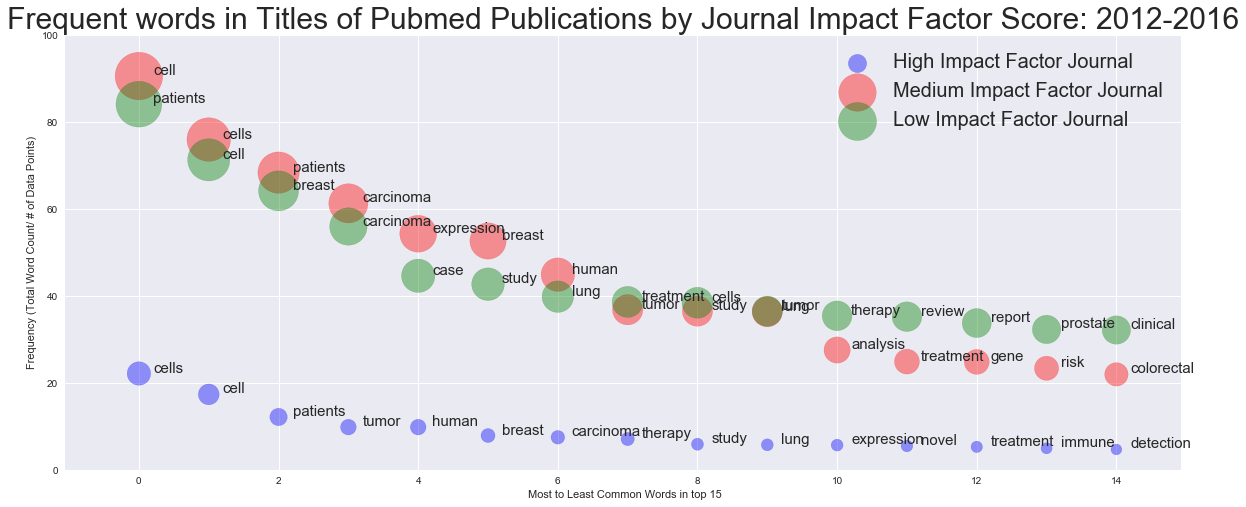

In [90]:
tfidf_plotting(df = rslt_all_highifj, y='Frequency', label='Word', N= 15, color = 'blue')
tfidf_plotting(df = rslt_all_medifj, y='Frequency', label='Word', N= 15, color = 'red')
tfidf_plotting(df = rslt_all_lowifj, y='Frequency', label='Word', N= 15, color = 'green')

fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 20
fig_size[1] = 10



plt.rcParams["figure.figsize"] = fig_size
plt.ylim(ymax=100, ymin=0 )
plt.title('Frequent words in Titles of Pubmed Publications by Journal Impact Factor Score: 2012-2016', fontsize= 30)
plt.ylabel( 'Frequency (Total Word Count/ # of Data Points)')
plt.xlabel(" Most to Least Common Words in top 15")
plt.legend( ('High Impact Factor Journal', 'Medium Impact Factor Journal', 'Low Impact Factor Journal'),
           loc= 'best', fontsize= 20, markerscale=1)

plt.show()

In [24]:
def tfidf_plotting_bar(df, y, label, N, color):
    df= df.reset_index()
    df.sort_values(by=[y])
    X= df.index[0:N]
    Y=((df[y][0:N])/len(df))
    n = df[label][0:N]

    plot=plt.bar(x= X, y = Y, alpha=0.4, c= color)
    ax = plt.subplot()
    for i, txt in enumerate(n):
        ax.annotate(txt, (X[i],Y[i]), xytext=(X[i]+0.2,Y[i]+0.3), fontsize= 15)

In [24]:
df_ifj_all.sort_values( 'Journal Impact Factor',ascending= False)

,Year,Month,Paper Title,Abstract,First Author Name,Journal Name,Journal Abb.,Language,Rank,Full Journal Title,Total Cites,Journal Impact Factor,Eigenfactor Score,JIF_group
18089,2017,12,Graphene Oxide-Upconversion Nanoparticle Based...,"""The development of new sensors for the accura...","'Vilela', 'Patrick'",acs sensors,ACS Sens,eng,12062,acs sensors,245,Not Available,0.000060,high
18342,2016,9,In vitro Detection of Hypoxia using a Ratiomet...,'A quantum-dot based ratiometric fluorescent o...,"'Shamirian', 'Armen'",acs sensors,ACS Sens,eng,12062,acs sensors,245,Not Available,0.000060,high
21741,2017,12,Rational Design of Selective Allosteric Inhibi...,'Metabolic reprogramming in cancer cells facil...,"'Wang', 'Qian'",cell chemical biology,Cell Chem Biol,eng,12062,cell chemical biology,194,Not Available,0.000000,high
21742,2017,12,Systems Structural Biology Analysis of Ligand ...,'Environmental estrogens and anti-hormone ther...,"'Nwachukwu', 'Jerome C'",cell chemical biology,Cell Chem Biol,eng,12062,cell chemical biology,194,Not Available,0.000000,high
18090,2017,10,Multi-Amplified Sensing of MicroRNA by a Small...,'Combining technological developments such as ...,"'Kim', 'Eunjung'",acs sensors,ACS Sens,eng,12062,acs sensors,245,Not Available,0.000060,high
19861,2017,12,Five cases of acrometastasis to the hand from ...,'Metastases in the hand bones are a rare form ...,"'Muñoz-Mahamud', 'E'",hand surgery & rehabilitation,Hand Surg Rehabil,eng,12062,hand surgery & rehabilitation,3,Not Available,0.000000,high
18088,2017,12,Highlighting Cancer Cells with Halochromic Swi...,'Halochromic coumarin-oxazine prefluorophores ...,"'Tang', 'Sicheng'",acs sensors,ACS Sens,eng,12062,acs sensors,245,Not Available,0.000060,high
17649,2017,9,"Sexual Orientation, Gender, and Environmental ...",'Disparate residential hazard exposures based ...,"'Collins', 'Timothy W'",annals of the american association of geographers,Ann Am Assoc Geogr,eng,12062,annals of the american association of geographers,32,Not Available,0.000000,high
6000,2014,12,The good and the bad of being connected: the i...,"""Over 40 years ago, Francois Jacob proposed th...","'Dillin', 'Andrew'",current opinion in cell biology,Curr. Opin. Cell Biol.,eng,214,current opinion in cell biology,"13,266",9.937,0.029670,high
5229,2014,11,Role of G protein-coupled receptor kinases in ...,'G protein-coupled receptor kinases (GRKs) are...,"'Penela', 'Petronila'",current opinion in cell biology,Curr. Opin. Cell Biol.,eng,214,current opinion in cell biology,"13,266",9.937,0.029670,high


In [25]:
word_freq(df_ifj12_high,'Paper Title', 15)
rslt_highifj = word_freq.rslt

word_freq(df_ifj12_med,'Paper Title',15)
rslt_medifj = word_freq.rslt

word_freq(df_ifj12_low,'Paper Title',15)
rslt_lowifj = word_freq.rslt

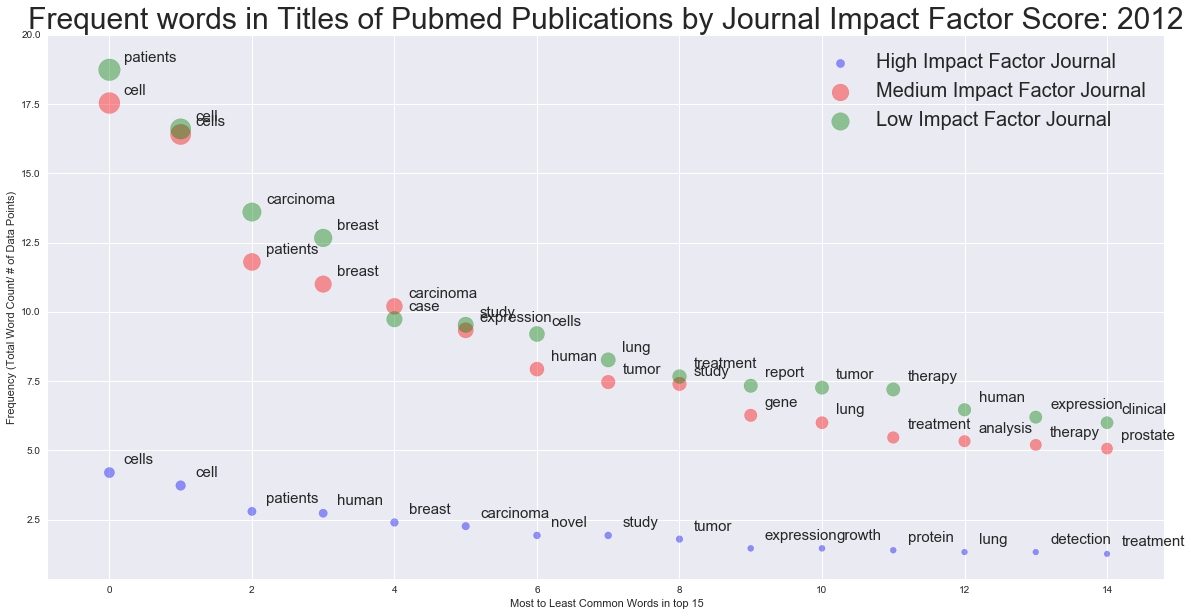

In [92]:
tfidf_plotting(df = rslt_highifj, y='Frequency', label='Word', N= 15, color = 'blue')
tfidf_plotting(df = rslt_medifj, y='Frequency', label='Word', N= 15, color = 'red')
tfidf_plotting(df = rslt_lowifj, y='Frequency', label='Word', N= 15, color = 'green')

fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 20
fig_size[1] = 8



plt.rcParams["figure.figsize"] = fig_size
plt.title('Frequent words in Titles of Pubmed Publications by Journal Impact Factor Score: 2012', fontsize= 30)
plt.ylabel( 'Frequency (Total Word Count/ # of Data Points)')
plt.xlabel(" Most to Least Common Words in top 15")
plt.legend( ('High Impact Factor Journal', 'Medium Impact Factor Journal', 'Low Impact Factor Journal'),
           loc= 'best', fontsize= 20, markerscale=1)

plt.show()

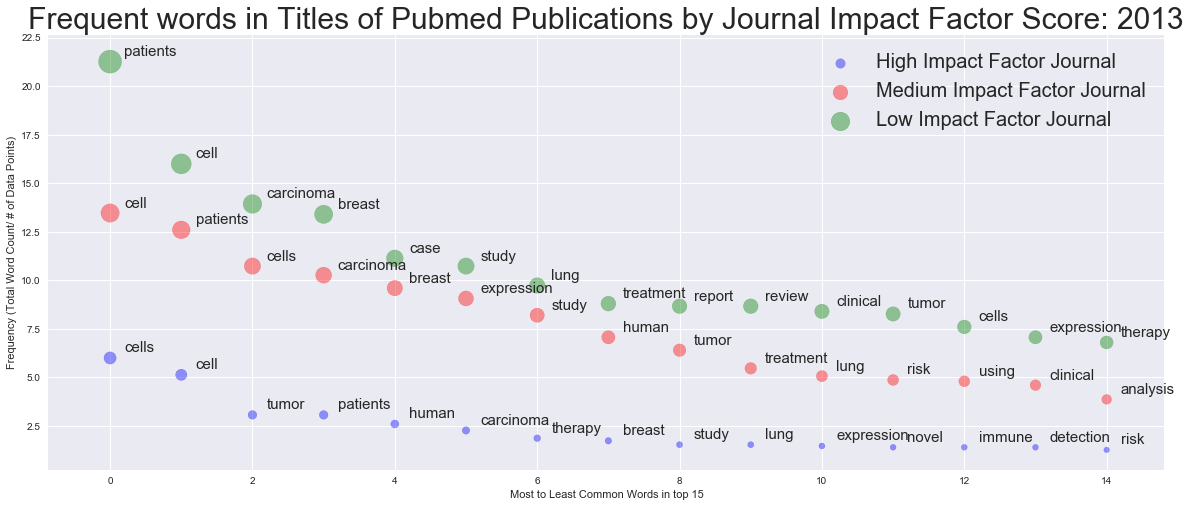

In [93]:
word_freq(df_ifj13_high,'Paper Title', 15)
rslt_highifj = word_freq.rslt

word_freq(df_ifj13_med,'Paper Title',15)
rslt_medifj = word_freq.rslt

word_freq(df_ifj13_low,'Paper Title',15)
rslt_lowifj = word_freq.rslt

tfidf_plotting(df = rslt_highifj, y='Frequency', label='Word', N= 15, color = 'blue')
tfidf_plotting(df = rslt_medifj, y='Frequency', label='Word', N= 15, color = 'red')
tfidf_plotting(df = rslt_lowifj, y='Frequency', label='Word', N= 15, color = 'green')

fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 20
fig_size[1] = 8



plt.rcParams["figure.figsize"] = fig_size
plt.title('Frequent words in Titles of Pubmed Publications by Journal Impact Factor Score: 2013', fontsize= 30)
plt.ylabel( 'Frequency (Total Word Count/ # of Data Points)')
plt.xlabel(" Most to Least Common Words in top 15")
plt.legend( ('High Impact Factor Journal', 'Medium Impact Factor Journal', 'Low Impact Factor Journal'),
           loc= 'best', fontsize= 20, markerscale=1)

plt.show()

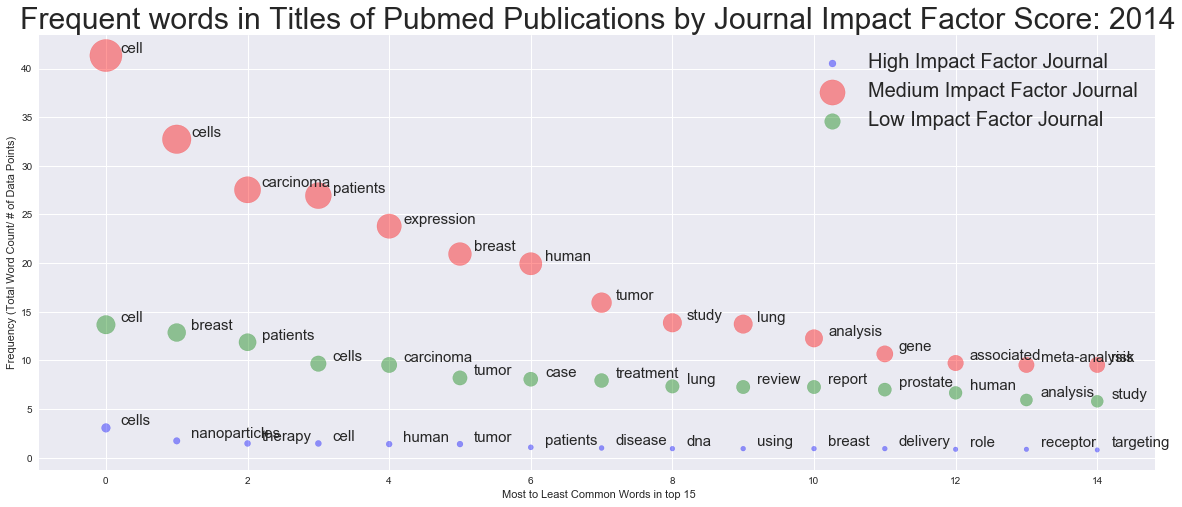

In [29]:
word_freq(df_ifj14_high,'Paper Title', 15)
rslt_highifj = word_freq.rslt

word_freq(df_ifj14_med,'Paper Title',15)
rslt_medifj = word_freq.rslt

word_freq(df_ifj14_low,'Paper Title',15)
rslt_lowifj = word_freq.rslt

tfidf_plotting(df = rslt_highifj, y='Frequency', label='Word', N= 15, color = 'blue')
tfidf_plotting(df = rslt_medifj, y='Frequency', label='Word', N= 15, color = 'red')
tfidf_plotting(df = rslt_lowifj, y='Frequency', label='Word', N= 15, color = 'green')

fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 20
fig_size[1] = 8



plt.rcParams["figure.figsize"] = fig_size
plt.title('Frequent words in Titles of Pubmed Publications by Journal Impact Factor Score: 2014', fontsize= 30)
plt.ylabel( 'Frequency (Total Word Count/ # of Data Points)')
plt.xlabel(" Most to Least Common Words in top 15")
plt.legend( ('High Impact Factor Journal', 'Medium Impact Factor Journal', 'Low Impact Factor Journal'),
           loc= 'best', fontsize= 20, markerscale=1)

plt.show()

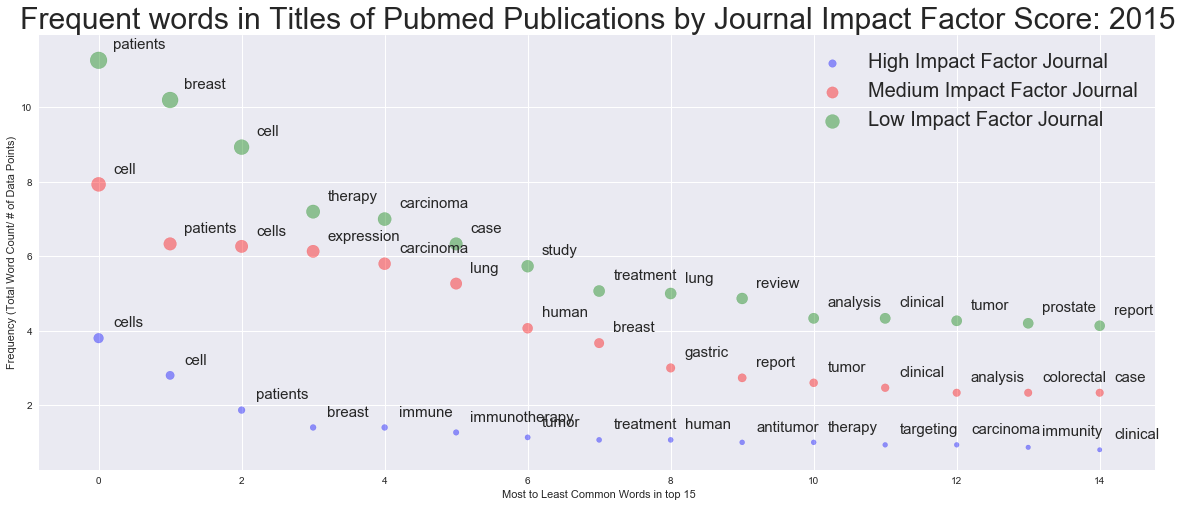

In [30]:
word_freq(df_ifj15_high,'Paper Title', 15)
rslt_highifj = word_freq.rslt

word_freq(df_ifj15_med,'Paper Title',15)
rslt_medifj = word_freq.rslt

word_freq(df_ifj15_low,'Paper Title',15)
rslt_lowifj = word_freq.rslt

tfidf_plotting(df = rslt_highifj, y='Frequency', label='Word', N= 15, color = 'blue')
tfidf_plotting(df = rslt_medifj, y='Frequency', label='Word', N= 15, color = 'red')
tfidf_plotting(df = rslt_lowifj, y='Frequency', label='Word', N= 15, color = 'green')

fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 20
fig_size[1] = 8



plt.rcParams["figure.figsize"] = fig_size
plt.title('Frequent words in Titles of Pubmed Publications by Journal Impact Factor Score: 2015', fontsize= 30)
plt.ylabel( 'Frequency (Total Word Count/ # of Data Points)')
plt.xlabel(" Most to Least Common Words in top 15")
plt.legend( ('High Impact Factor Journal', 'Medium Impact Factor Journal', 'Low Impact Factor Journal'),
           loc= 'best', fontsize= 20, markerscale=1)

plt.show()

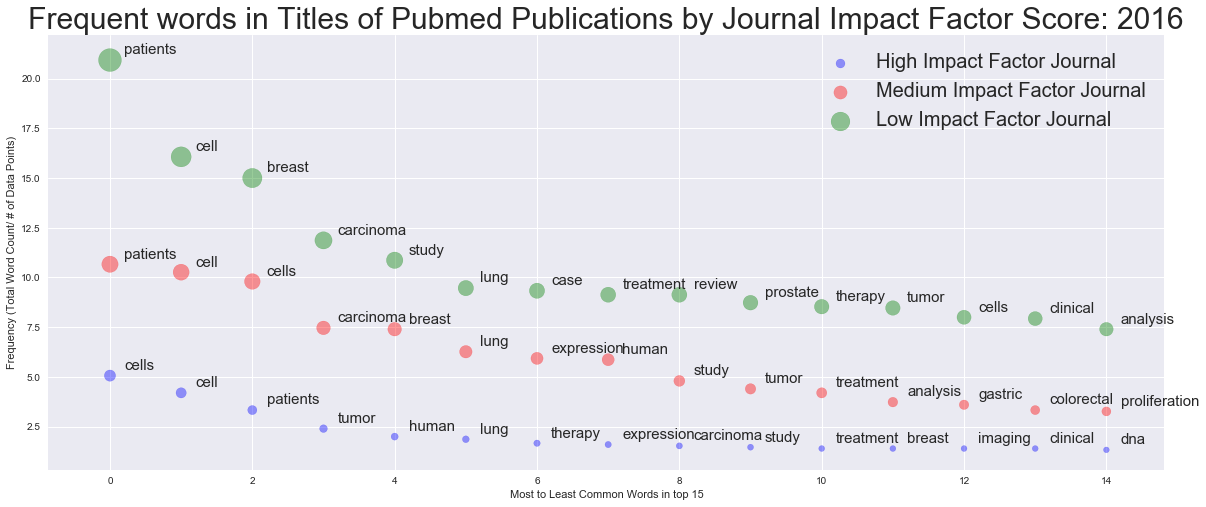

In [762]:
word_freq(df_ifj16_high,'Paper Title', 15)
rslt_highifj = word_freq.rslt

word_freq(df_ifj16_med,'Paper Title',15)
rslt_medifj = word_freq.rslt

word_freq(df_ifj16_low,'Paper Title',15)
rslt_lowifj = word_freq.rslt

tfidf_plotting(df = rslt_highifj, y='Frequency', label='Word', N= 15, color = 'blue')
tfidf_plotting(df = rslt_medifj, y='Frequency', label='Word', N= 15, color = 'red')
tfidf_plotting(df = rslt_lowifj, y='Frequency', label='Word', N= 15, color = 'green')

fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 20
fig_size[1] = 8



plt.rcParams["figure.figsize"] = fig_size
plt.title('Frequent words in Titles of Pubmed Publications by Journal Impact Factor Score: 2016', fontsize= 30)
plt.ylabel( 'Frequency (Total Word Count/ # of Data Points)')
plt.xlabel(" Most to Least Common Words in top 15")
plt.legend( ('High Impact Factor Journal', 'Medium Impact Factor Journal', 'Low Impact Factor Journal'),
           loc= 'best', fontsize= 20, markerscale=1)

plt.show()

## thoughts from frequency
This result is very interesting. There are more journals in the "low" category total then high (potentially 33% vs 10%) but, given that the Y column is divided by the total number of data points in each group- the flat numbers should be comparable. Therefore, it looks like from this initial finding that papers published in higher impact journals use unusual or less common words in their titles, more often then low impact journal publications- even if the most frequent words (not evaluated for IDF or topic-specific stop words) are generally similar ('cell', 'cells', 'cancer', 'breast' & etc.) 

This may be due to increased frequency of unusual words (a specific drug, protein, or gene) in high-impact-papers rather then general terms like 'tumors' 'breast' or 'expression'. 
    
       - It could therefore be a reflection of what is termed 'basic science' papers (about more general topics) being in low impact journals vs. 'applied science' in high-impact jouranls. But the data is much too loose to make any conclusions beyond speculation. 

# Next Step: TF-IDF from year-to-year AND high-to-low

To do the next step I am going to run a TFIDF function that works well, putting all the findings into simple dataframes w/ the tf-idf score. 

To keep the info I have so painstackingly made (that is seperate by high-med-and-low) I will run each list as a seperate 'document' against the entire corpus of the whole. 

Because the entire corpus wil be very large (including all the Titles, Abstracts and seperated by list) I am using a different form of TF-IDF then before: Gensim w/ Sklearn- which iterates over a matrix of the corpus that is saved- rather then the complete corpus like Textblob which I used previously.

# But First, How do the general clustering of TFIDF scores compare?


In [26]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt

pipeline = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
]) 

In [27]:
# given how many groups of df or documents I am now working with 
#(5 years, and 3 groups within each group!) I am using functions to stream line and organize results
def PCA_fit_highlow_fromdf(df, column):
    df_high, df_med, df_low = split_tfidf_score(df)
    r_1= pipeline.fit_transform(df_high[column]).todense()
    r_2= pipeline.fit_transform(df_med[column]).todense()
    r_3= pipeline.fit_transform(df_low[column]).todense()
    return r_1, r_2, r_3

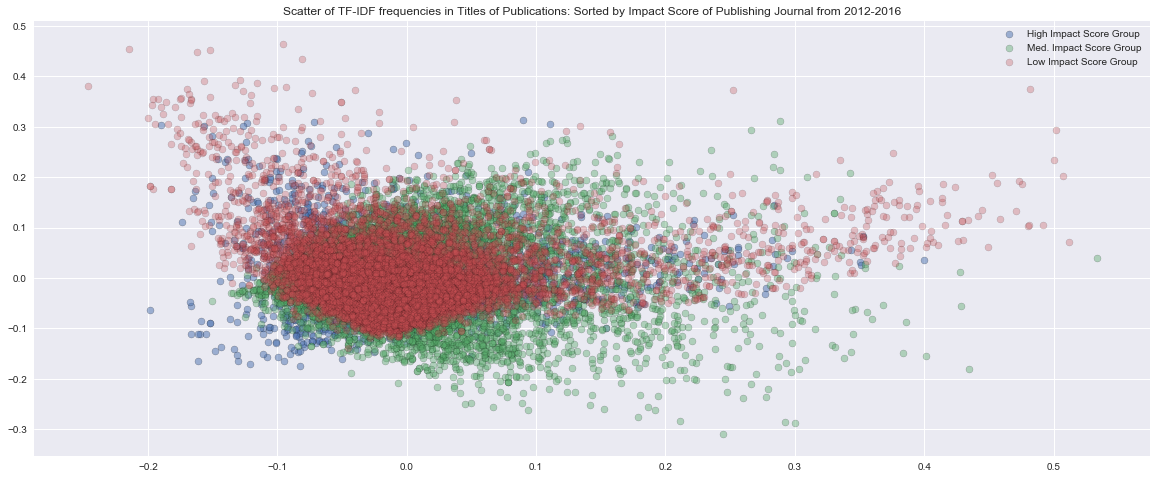

In [96]:
import matplotlib.cm as cm
colors=cm.rainbow(np.random.rand(33))

X, Y, Z = PCA_fit_highlow_fromdf(df_all_wIFJ, 'Paper Title')
pca = PCA(n_components=2).fit(X)
data2D = pca.transform(X)
_13=plt.scatter(data2D[:,0], data2D[:,1],label= 'All Docs- High Impact Score Group', alpha= 0.5, edgecolor= 'black')

pca = PCA(n_components=2).fit(Y)
data2D = pca.transform(Y)
_14=plt.scatter(data2D[:,0], data2D[:,1],  label= 'All Docs- Med. Impact Score Group', alpha= 0.4, edgecolor= 'black')

pca = PCA(n_components=2).fit(Z)
data2D = pca.transform(Z)
_15=plt.scatter(data2D[:,0], data2D[:,1], label= 'All Docs- Low Impact Score Group', alpha= 0.3, edgecolor= 'black')

plt.title ('Scatter of TF-IDF frequencies in Titles of Publications: Sorted by Impact Score of Publishing Journal from 2012-2016')
plt.legend((_13, _14,_15),( 'High Impact Score Group', 'Med. Impact Score Group', 'Low Impact Score Group'), loc='upper right')
plt.show()

# First Thoughts:
There is a deffinite difference in the clustering- although the results seem to have a similar cone-like shape

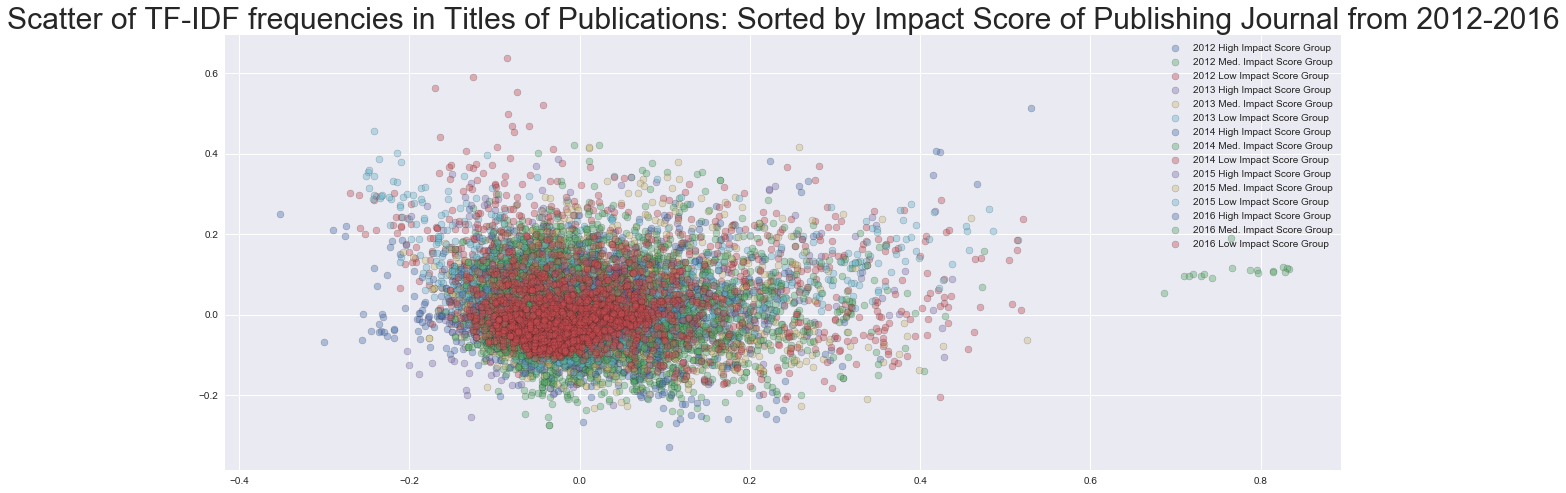

In [97]:
# This may be hard to visuzalize, but looking at clustering
# for ALL the data points from all 5 years at one time
import matplotlib.cm as cm
colors=cm.rainbow(np.random.rand(15))

X, Y, Z = PCA_fit_highlow_fromdf(df_12_wIFJ, 'Paper Title')
pca = PCA(n_components=2).fit(X)
data2D = pca.transform(X)
_12h=plt.scatter(data2D[:,0], data2D[:,1],label= '2012- High Impact Score Group', alpha= 0.4, edgecolor= 'black')

pca = PCA(n_components=2).fit(Y)
data2D = pca.transform(Y)
_12m=plt.scatter(data2D[:,0], data2D[:,1],  label= '2012- Med. Impact Score Group', alpha= 0.4, edgecolor= 'black')

pca = PCA(n_components=2).fit(Z)
data2D = pca.transform(Z)
_12l=plt.scatter(data2D[:,0], data2D[:,1], label= '2012- Low Impact Score Group', alpha= 0.4, edgecolor= 'black')


X, Y, Z = PCA_fit_highlow_fromdf(df_13_wIFJ, 'Paper Title')
pca = PCA(n_components=2).fit(X)
data2D = pca.transform(X)
_13h=plt.scatter(data2D[:,0], data2D[:,1],label= '2013- High Impact Score Group', alpha= 0.4, edgecolor= 'black')

pca = PCA(n_components=2).fit(Y)
data2D = pca.transform(Y)
_13m=plt.scatter(data2D[:,0], data2D[:,1],  label= '2013- Med. Impact Score Group', alpha= 0.4, edgecolor= 'black')

pca = PCA(n_components=2).fit(Z)
data2D = pca.transform(Z)
_13l=plt.scatter(data2D[:,0], data2D[:,1], label= '2013- Low Impact Score Group', alpha= 0.4, edgecolor= 'black')


X, Y, Z = PCA_fit_highlow_fromdf(df_14_wIFJ, 'Paper Title')
pca = PCA(n_components=2).fit(X)
data2D = pca.transform(X)
_14h=plt.scatter(data2D[:,0], data2D[:,1],label= '2014- High Impact Score Group', alpha= 0.4, edgecolor= 'black')

pca = PCA(n_components=2).fit(Y)
data2D = pca.transform(Y)
_14m=plt.scatter(data2D[:,0], data2D[:,1],  label= '2014- Med. Impact Score Group', alpha= 0.4, edgecolor= 'black')

pca = PCA(n_components=2).fit(Z)
data2D = pca.transform(Z)
_14l=plt.scatter(data2D[:,0], data2D[:,1], label= '2014- Low Impact Score Group', alpha= 0.4, edgecolor= 'black')



X, Y, Z = PCA_fit_highlow_fromdf(df_15_wIFJ, 'Paper Title')
pca = PCA(n_components=2).fit(X)
data2D = pca.transform(X)
_15h=plt.scatter(data2D[:,0], data2D[:,1],label= '2015- High Impact Score Group', alpha= 0.4, edgecolor= 'black')

pca = PCA(n_components=2).fit(Y)
data2D = pca.transform(Y)
_15m=plt.scatter(data2D[:,0], data2D[:,1],  label= '2015- Med. Impact Score Group', alpha= 0.4, edgecolor= 'black')

pca = PCA(n_components=2).fit(Z)
data2D = pca.transform(Z)
_15l=plt.scatter(data2D[:,0], data2D[:,1], label= '2015- Low Impact Score Group', alpha= 0.4, edgecolor= 'black')




X, Y, Z = PCA_fit_highlow_fromdf(df_16_wIFJ, 'Paper Title')
pca = PCA(n_components=2).fit(X)
data2D = pca.transform(X)
_16h=plt.scatter(data2D[:,0], data2D[:,1],label= '2016- High Impact Score Group', alpha= 0.4, edgecolor= 'black')

pca = PCA(n_components=2).fit(Y)
data2D = pca.transform(Y)
_16m=plt.scatter(data2D[:,0], data2D[:,1],  label= '2016- Med. Impact Score Group', alpha= 0.4, edgecolor= 'black')

pca = PCA(n_components=2).fit(Z)
data2D = pca.transform(Z)
_16l=plt.scatter(data2D[:,0], data2D[:,1], label= '2016- Low Impact Score Group', alpha= 0.4, edgecolor= 'black')


plt.title ('Scatter of TF-IDF frequencies in Titles of Publications: Sorted by Impact Score of Publishing Journal from 2012-2016',
          fontsize= 30)
plt.legend((_12h,_12m,_12l, _13h,_13m,_13l, _14h,_14m,_14l, _15h,_15m,_15l, _16h,_16m,_16l),
           ( '2012 High Impact Score Group', '2012 Med. Impact Score Group', '2012 Low Impact Score Group',
           '2013 High Impact Score Group', '2013 Med. Impact Score Group', '2013 Low Impact Score Group',
           '2014 High Impact Score Group', '2014 Med. Impact Score Group', '2014 Low Impact Score Group',
           '2015 High Impact Score Group', '2015 Med. Impact Score Group', '2015 Low Impact Score Group',
           '2016 High Impact Score Group', '2016 Med. Impact Score Group', '2016 Low Impact Score Group'),
           loc='upper right')
plt.show()

Although this is a bit of a mess of information- I did set the High as blue colors, medium as green and low as red/orange colors. Therefore it is possible to make some general observations. 

1) all five years follow a similar cluster trend of more high TF-IDF scores in Low-impact-journal publications (for titles) then high and medium impact journals. 

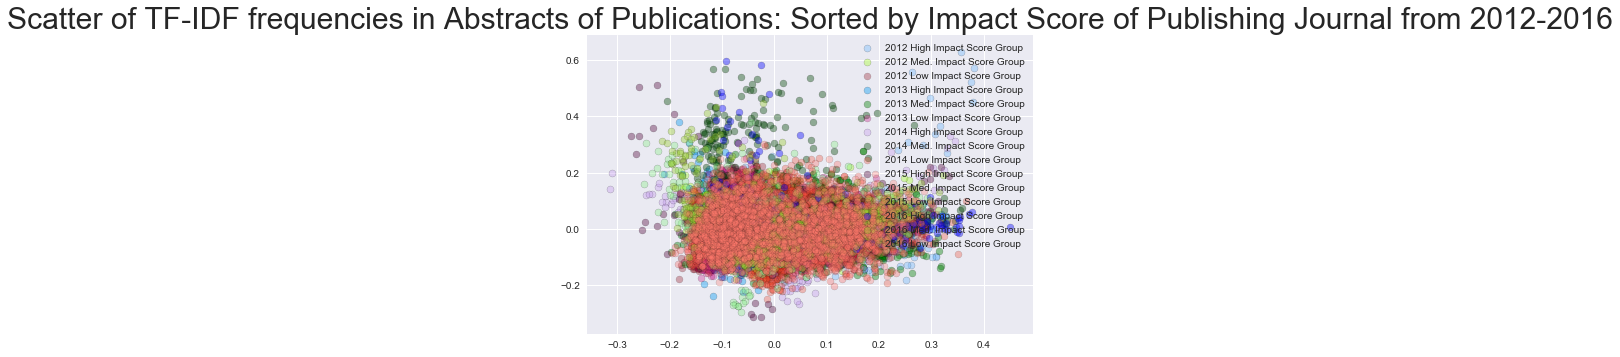

In [29]:
# Same As above- but looking at Abstracts
import matplotlib.cm as cm


X, Y, Z = PCA_fit_highlow_fromdf(df_12_wIFJ, 'Abstract')
pca = PCA(n_components=2).fit(X)
data2D = pca.transform(X)
_12h=plt.scatter(data2D[:,0], data2D[:,1],label= '2012- High Impact Score Group', 
                 alpha= 0.4, edgecolor= 'black', color= 'xkcd:sky blue')

pca = PCA(n_components=2).fit(Y)
data2D = pca.transform(Y)
_12m=plt.scatter(data2D[:,0], data2D[:,1],  label= '2012- Med. Impact Score Group', 
                 alpha= 0.4, edgecolor= 'black', color = 'xkcd:lime')

pca = PCA(n_components=2).fit(Z)
data2D = pca.transform(Z)
_12l=plt.scatter(data2D[:,0], data2D[:,1], label= '2012- Low Impact Score Group', 
                 alpha= 0.3, edgecolor= 'black', color= 'xkcd:crimson')


X, Y, Z = PCA_fit_highlow_fromdf(df_13_wIFJ, 'Abstract')
pca = PCA(n_components=2).fit(X)
data2D = pca.transform(X)
_13h=plt.scatter(data2D[:,0], data2D[:,1],label= '2013- High Impact Score Group', 
                 alpha= 0.4, edgecolor= 'black', color='xkcd:azure')

pca = PCA(n_components=2).fit(Y)
data2D = pca.transform(Y)
_13m=plt.scatter(data2D[:,0], data2D[:,1],  label= '2013- Med. Impact Score Group', 
                 alpha= 0.4, edgecolor= 'black', color= 'green')

pca = PCA(n_components=2).fit(Z)
data2D = pca.transform(Z)
_13l=plt.scatter(data2D[:,0], data2D[:,1], label= '2013- Low Impact Score Group',
                 alpha= 0.3, edgecolor= 'black', color='xkcd:magenta')


X, Y, Z = PCA_fit_highlow_fromdf(df_14_wIFJ, 'Abstract')
pca = PCA(n_components=2).fit(X)
data2D = pca.transform(X)
_14h=plt.scatter(data2D[:,0], data2D[:,1],label= '2014- High Impact Score Group', 
                 alpha= 0.4, edgecolor= 'black', color= 'xkcd:lavender')

pca = PCA(n_components=2).fit(Y)
data2D = pca.transform(Y)
_14m=plt.scatter(data2D[:,0], data2D[:,1],  label= '2014- Med. Impact Score Group', 
                 alpha= 0.4, edgecolor= 'black', color='xkcd:darkgreen')

pca = PCA(n_components=2).fit(Z)
data2D = pca.transform(Z)
_14l=plt.scatter(data2D[:,0], data2D[:,1], label= '2014- Low Impact Score Group', 
                 alpha= 0.3, edgecolor= 'black', color='xkcd:tomato')



X, Y, Z = PCA_fit_highlow_fromdf(df_15_wIFJ, 'Abstract')
pca = PCA(n_components=2).fit(X)
data2D = pca.transform(X)
_15h=plt.scatter(data2D[:,0], data2D[:,1],label= '2015- High Impact Score Group', 
                 alpha= 0.4, edgecolor= 'black', color= 'xkcd:plum')

pca = PCA(n_components=2).fit(Y)
data2D = pca.transform(Y)
_15m=plt.scatter(data2D[:,0], data2D[:,1],  label= '2015- Med. Impact Score Group', 
                 alpha= 0.4, edgecolor= 'black', color='lightgreen')

pca = PCA(n_components=2).fit(Z)
data2D = pca.transform(Z)
_15l=plt.scatter(data2D[:,0], data2D[:,1], label= '2015- Low Impact Score Group', 
                 alpha= 0.3, edgecolor= 'black', color='xkcd:coral')




X, Y, Z = PCA_fit_highlow_fromdf(df_16_wIFJ, 'Abstract')
pca = PCA(n_components=2).fit(X)
data2D = pca.transform(X)
_16h=plt.scatter(data2D[:,0], data2D[:,1],label= '2016- High Impact Score Group',
                 alpha= 0.4, edgecolor= 'black', color= 'blue')

pca = PCA(n_components=2).fit(Y)
data2D = pca.transform(Y)
_16m=plt.scatter(data2D[:,0], data2D[:,1],  label= '2016- Med. Impact Score Group', 
                 alpha= 0.4, edgecolor= 'black', color='yellowgreen')

pca = PCA(n_components=2).fit(Z)
data2D = pca.transform(Z)
_16l=plt.scatter(data2D[:,0], data2D[:,1], label= '2016- Low Impact Score Group', 
                 alpha= 0.3, edgecolor= 'black', color='xkcd:salmon')


plt.title ('Scatter of TF-IDF frequencies in Abstracts of Publications: Sorted by Impact Score of Publishing Journal from 2012-2016',
          fontsize= 30)
plt.legend((_12h,_12m,_12l, _13h,_13m,_13l, _14h,_14m,_14l, _15h,_15m,_15l, _16h,_16m,_16l),
           ( '2012 High Impact Score Group', '2012 Med. Impact Score Group', '2012 Low Impact Score Group',
           '2013 High Impact Score Group', '2013 Med. Impact Score Group', '2013 Low Impact Score Group',
           '2014 High Impact Score Group', '2014 Med. Impact Score Group', '2014 Low Impact Score Group',
           '2015 High Impact Score Group', '2015 Med. Impact Score Group', '2015 Low Impact Score Group',
           '2016 High Impact Score Group', '2016 Med. Impact Score Group', '2016 Low Impact Score Group'),
           loc='upper right')
plt.show()

# TF-IDF analysis

To run TF-IDF analysis first clean, and isolate hte data- and create a stop_words list, including most frequent phrases and words identified in the earlier frequency analysis. 

In [28]:
# use stuff from Datacamp and enumerate to go over all dataframes, isolate info from
# column of interest, and then get most common words for each year from the desired column
# in this example: Paper title and abstracts

# make a string of desired colums from df to build the corpus
def str_from_df(df, name, name2):
    titles_list = []
    for row in df[name]:
        temp_string = row
        titles_list.append(temp_string)
    titles_str= ' '.join(titles_list)
    for row in df[name2]:
        temp_string = row
        titles_list.append(temp_string)
    titles_str= ' '.join(titles_list)
    words= titles_str
    return words

In [29]:
df_tiabs_high= str_from_df(df_ifj_high, 'Paper Title', 'Abstract')

df_tiabs_12h= str_from_df(df_ifj12_high, 'Paper Title', 'Abstract')
df_tiabs_13h= str_from_df(df_ifj13_high, 'Paper Title', 'Abstract')
df_tiabs_14h= str_from_df(df_ifj14_high, 'Paper Title', 'Abstract')
df_tiabs_15h= str_from_df(df_ifj15_high, 'Paper Title', 'Abstract')
df_tiabs_16h= str_from_df(df_ifj16_high, 'Paper Title', 'Abstract')

df_tiabs_med= str_from_df(df_ifj_med, 'Paper Title', 'Abstract')

df_tiabs_12m= str_from_df(df_ifj12_med, 'Paper Title', 'Abstract')
df_tiabs_13m= str_from_df(df_ifj13_med, 'Paper Title', 'Abstract')
df_tiabs_14m= str_from_df(df_ifj14_med, 'Paper Title', 'Abstract')
df_tiabs_15m= str_from_df(df_ifj15_med, 'Paper Title', 'Abstract')
df_tiabs_16m= str_from_df(df_ifj16_med, 'Paper Title', 'Abstract')

df_tiabs_low= str_from_df(df_ifj_low, 'Paper Title', 'Abstract')

df_tiabs_12l= str_from_df(df_ifj12_low, 'Paper Title', 'Abstract')
df_tiabs_13l= str_from_df(df_ifj13_low, 'Paper Title', 'Abstract')
df_tiabs_14l= str_from_df(df_ifj14_low, 'Paper Title', 'Abstract')
df_tiabs_15l= str_from_df(df_ifj15_low, 'Paper Title', 'Abstract')
df_tiabs_16l= str_from_df(df_ifj16_low, 'Paper Title', 'Abstract')

 -- could I run the strings through as a dataframe with group and year in columns with strings in one largeeeee column. 

In [168]:
# addingmost frequent words from all data in paper titles and abstracts as stop words 
from sklearn.feature_extraction import text 

# most common words from earlier TF- analysis from both All-Titles list and All-Abstracts list 
titles_common= ('cell', 'patients','patient','stringelement', 'cells', 'study','expression', 'tumor','tumour', 'human', 
                 'treatment', 'therapy', 'case','analysis', 'review', 'methods',
                'patients', '%', 'label', 'nlmcategory', '}', 'cells', 'cell', 'results', 'cancer', 'attributes')
stop_words = text.ENGLISH_STOP_WORDS.union(titles_common)

In [63]:
# Import TfidfModel
from gensim.models.tfidfmodel import TfidfModel

# define corpus 

full_list= ( df_tiabs_12h, df_tiabs_12m, df_tiabs_12l,
        df_tiabs_13h, df_tiabs_13m, df_tiabs_13l,
        df_tiabs_14h, df_tiabs_14m, df_tiabs_14l,
        df_tiabs_15h, df_tiabs_15m, df_tiabs_15l,
        df_tiabs_16h, df_tiabs_16m, df_tiabs_16l)
# Create a new TfidfModel using the corpus: tfidf

from sklearn.feature_extraction.text import TfidfVectorizer
v = TfidfVectorizer(analyzer= 'word', ngram_range=(1, 3), min_df= 0, stop_words= stop_words)
x = v.fit_transform(full_list)
feature_names= v.get_feature_names()


In [67]:
def top_tfidf_feats(row, features, top_n=25):
# Get top n tfidf values in row and return them with their corresponding feature names.
    topn_ids = np.argsort(row)[::-1][:top_n]
    top_feats = [(features[i], row[i]) for i in topn_ids]
    df = pd.DataFrame(top_feats)
    df.columns = ['Word', 'tfidf']
    return df

In [68]:
def top_mean_feats(Xtr, features, grp_ids=None, min_tfidf=0.1, top_n=25):
# Return the top n features that on average are most important amongst documents
    if grp_ids:
        D = Xtr[grp_ids].toarray()
    else:
        D = Xtr.toarray()

    D[D < min_tfidf] = 0
    tfidf_means = np.mean(D, axis=0)
    return top_tfidf_feats(tfidf_means, features, top_n)

In [69]:
tfidf_12_high= top_mean_feats(x, feature_names, grp_ids=0 )
tfidf_12_med= top_mean_feats(x, feature_names, grp_ids=1 )
tfidf_12_low= top_mean_feats(x, feature_names, grp_ids=2 )

tfidf_13_high= top_mean_feats(x, feature_names, grp_ids=3 )
tfidf_13_med= top_mean_feats(x, feature_names, grp_ids=4 )
tfidf_13_low= top_mean_feats(x, feature_names, grp_ids=5 )

tfidf_14_high= top_mean_feats(x, feature_names, grp_ids=6 )
tfidf_14_med= top_mean_feats(x, feature_names, grp_ids=7 )
tfidf_14_low= top_mean_feats(x, feature_names, grp_ids=8 )

tfidf_15_high= top_mean_feats(x, feature_names, grp_ids=9 )
tfidf_15_med= top_mean_feats(x, feature_names, grp_ids=10)
tfidf_15_low= top_mean_feats(x, feature_names, grp_ids=11)

tfidf_16_high= top_mean_feats(x, feature_names, grp_ids=12)
tfidf_16_med= top_mean_feats(x, feature_names, grp_ids=13)
tfidf_16_low= top_mean_feats(x, feature_names, grp_ids=14)

# Visualize and Analyze

Adding group listing and year to each group and then re-concatenate into a DF to make it easier to work with. 

In [70]:
def add_year_group(df, year, group):
    new_df= df
    new_df= new_df.assign(IF_score_group= group)
    new_df= new_df.assign(Year = year)
    return new_df

In [71]:
# group together to compare results
# first add year to each DF
tfidf_12_high= add_year_group(tfidf_12_high, '2012', 'high')
tfidf_12_med= add_year_group(tfidf_12_med, '2012', 'med')
tfidf_12_low= add_year_group(tfidf_12_low, '2012', 'low')

tfidf_13_high= add_year_group(tfidf_13_high, '2013', 'high')
tfidf_13_med= add_year_group(tfidf_13_med, '2013', 'med')
tfidf_13_low= add_year_group(tfidf_13_low, '2013', 'low')

tfidf_14_high= add_year_group(tfidf_14_high, '2014', 'high')
tfidf_14_med= add_year_group(tfidf_14_med, '2014', 'med')
tfidf_14_low= add_year_group(tfidf_14_low, '2014', 'low')

tfidf_15_high= add_year_group(tfidf_15_high, '2015', 'high')
tfidf_15_med= add_year_group(tfidf_15_med, '2015', 'med')
tfidf_15_low= add_year_group(tfidf_15_low, '2015', 'low')

tfidf_16_high= add_year_group(tfidf_16_high, '2016', 'high')
tfidf_16_med= add_year_group(tfidf_16_med, '2016', 'med')
tfidf_16_low= add_year_group(tfidf_16_low, '2016', 'low')

#put all data into a single DF
group_all = [tfidf_12_high, tfidf_12_med, tfidf_12_low, tfidf_13_high, tfidf_13_med, tfidf_13_low,
            tfidf_14_high, tfidf_14_med, tfidf_14_low, tfidf_15_high, tfidf_15_med, tfidf_15_low,
            tfidf_16_high, tfidf_16_med, tfidf_16_low]
df_groups_tfidf = pd.concat(group_all)

In [72]:
df_groups_tfidf.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 375 entries, 0 to 24
Data columns (total 4 columns):
Word              375 non-null object
tfidf             375 non-null float64
IF_score_group    375 non-null object
Year              375 non-null object
dtypes: float64(1), object(3)
memory usage: 14.6+ KB


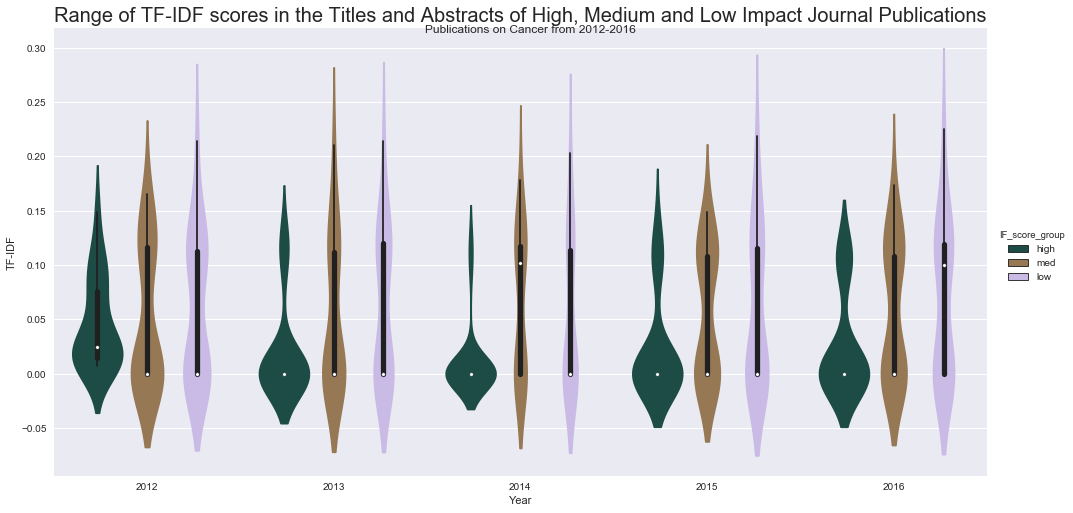

In [46]:

g = sns.factorplot( y= "tfidf", x= "Year", hue= 'IF_score_group', 
                   data=df_groups_tfidf, kind="violin", palette = 'cubehelix', size= 7, aspect= 2)
g.set_axis_labels("Year", "TF-IDF")
plt.title('Range of TF-IDF scores in the Titles and Abstracts of High, Medium and Low Impact Journal Publications', fontsize= 20)
plt.suptitle('Publications on Cancer from 2012-2016', fontsize= 12)
plt.show()

## Looking at the results averaged across all five years (below) rather then seperated by year, the overall result becomes more obvious. 

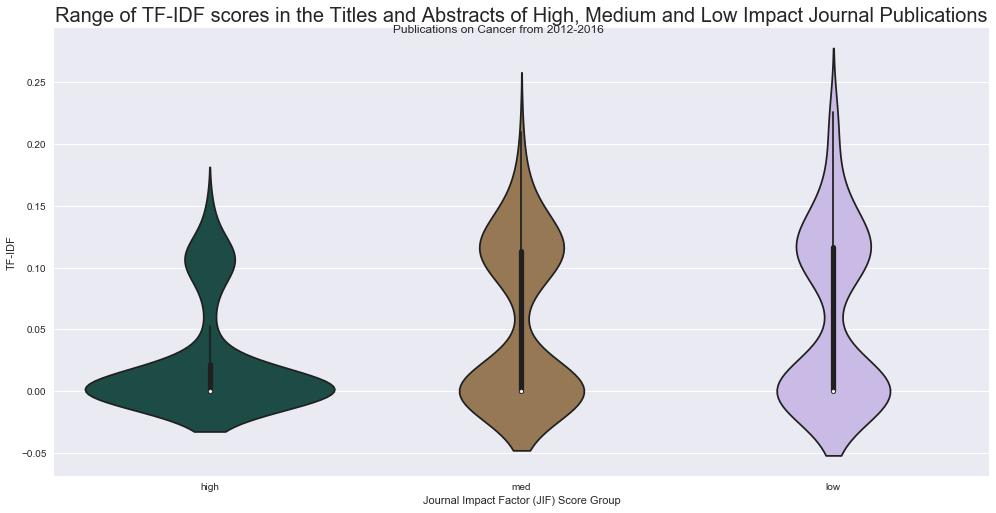

In [47]:


g = sns.factorplot( y= "tfidf", x= 'IF_score_group', 
                   data=df_groups_tfidf, kind="violin", palette = 'cubehelix', size= 7, aspect= 2)
g.set_axis_labels("Journal Impact Factor (JIF) Score Group", "TF-IDF")
plt.title('Range of TF-IDF scores in the Titles and Abstracts of High, Medium and Low Impact Journal Publications', fontsize= 20)
plt.suptitle('Publications on Cancer from 2012-2016', fontsize= 12)
plt.show()

## looking at the same results as above in a bar graph with range bars, to see if it more clearly visualizes the difference

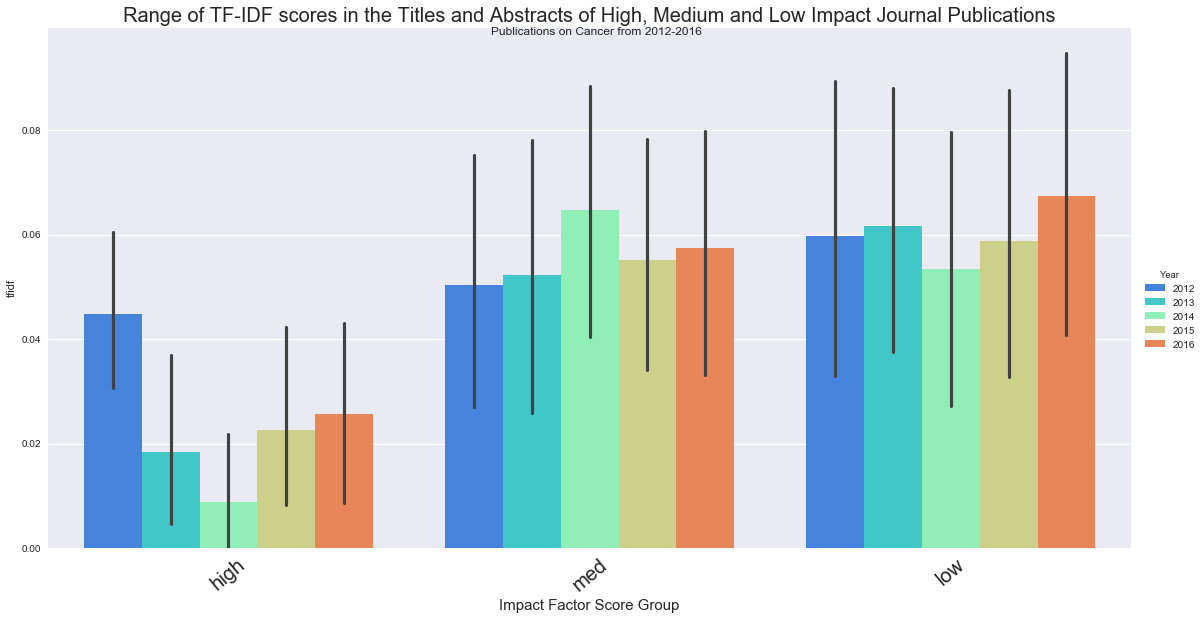

In [48]:
import matplotlib.cm as cm
colors=cm.rainbow(np.random.rand(15))

g = sns.factorplot( x= "IF_score_group", y= 'tfidf', hue= 'Year',
                   data=df_groups_tfidf, kind="bar", palette = 'rainbow', size= 8, aspect= 2)
plt.xlabel("Impact Factor Score Group", fontsize= 15)
plt.title('Range of TF-IDF scores in the Titles and Abstracts of High, Medium and Low Impact Journal Publications', fontsize= 20)
plt.suptitle('Publications on Cancer from 2012-2016', fontsize= 12)
plt.xticks(rotation=40, fontsize= 20)

plt.show()

# Thoughts
There is the fattest point in high impact journals- which means there may be a set of words to not use, or to deffinitly use to increase your chance of publication in a high impact journal. However, due to the high level of overlap above I suspect it won't change results by much. 

So if there are words more commonly 'over-used' in Low Impact Journals then in publications in High Impact Journals - what are those words?
What Words are in high frequency in low and medium impact papers that are not found (or found in reduced rates) in high impact journals? 

### And once we find those words- what can those words tell us about Impact Journal scores?

In [78]:

# Create a new TfidfModel using the corpus: tfidf looking at single words, not sets of words

from sklearn.feature_extraction.text import TfidfVectorizer
v = TfidfVectorizer(analyzer= 'word', ngram_range=(1, 1), min_df= 0, stop_words= stop_words)
x = v.fit_transform(full_list)
feature_names= v.get_feature_names()


In [85]:
tfidf_12_high= top_mean_feats(x, feature_names, grp_ids=0 )
tfidf_12_med= top_mean_feats(x, feature_names, grp_ids=1 )
tfidf_12_low= top_mean_feats(x, feature_names, grp_ids=2 )

tfidf_13_high= top_mean_feats(x, feature_names, grp_ids=3 )
tfidf_13_med= top_mean_feats(x, feature_names, grp_ids=4 )
tfidf_13_low= top_mean_feats(x, feature_names, grp_ids=5 )

tfidf_14_high= top_mean_feats(x, feature_names, grp_ids=6 )
tfidf_14_med= top_mean_feats(x, feature_names, grp_ids=7 )
tfidf_14_low= top_mean_feats(x, feature_names, grp_ids=8 )

tfidf_15_high= top_mean_feats(x, feature_names, grp_ids=9 )
tfidf_15_med= top_mean_feats(x, feature_names, grp_ids=10)
tfidf_15_low= top_mean_feats(x, feature_names, grp_ids=11)

tfidf_16_high= top_mean_feats(x, feature_names, grp_ids=12)
tfidf_16_med= top_mean_feats(x, feature_names, grp_ids=13)
tfidf_16_low= top_mean_feats(x, feature_names, grp_ids=14)

In [86]:
# group together to compare results
# first add year to each DF
tfidf_12_high= add_year_group(tfidf_12_high, '2012', 'high')
tfidf_12_med= add_year_group(tfidf_12_med, '2012', 'med')
tfidf_12_low= add_year_group(tfidf_12_low, '2012', 'low')

tfidf_13_high= add_year_group(tfidf_13_high, '2013', 'high')
tfidf_13_med= add_year_group(tfidf_13_med, '2013', 'med')
tfidf_13_low= add_year_group(tfidf_13_low, '2013', 'low')

tfidf_14_high= add_year_group(tfidf_14_high, '2014', 'high')
tfidf_14_med= add_year_group(tfidf_14_med, '2014', 'med')
tfidf_14_low= add_year_group(tfidf_14_low, '2014', 'low')

tfidf_15_high= add_year_group(tfidf_15_high, '2015', 'high')
tfidf_15_med= add_year_group(tfidf_15_med, '2015', 'med')
tfidf_15_low= add_year_group(tfidf_15_low, '2015', 'low')

tfidf_16_high= add_year_group(tfidf_16_high, '2016', 'high')
tfidf_16_med= add_year_group(tfidf_16_med, '2016', 'med')
tfidf_16_low= add_year_group(tfidf_16_low, '2016', 'low')

#put all data into a single DF
group_all = [tfidf_12_high, tfidf_12_med, tfidf_12_low, tfidf_13_high, tfidf_13_med, tfidf_13_low,
            tfidf_14_high, tfidf_14_med, tfidf_14_low, tfidf_15_high, tfidf_15_med, tfidf_15_low,
            tfidf_16_high, tfidf_16_med, tfidf_16_low]
df_groups_tfidf = pd.concat(group_all)

In [91]:
# sort by highest TF-IDF score in low impact jouranl reasults for each year and look at those
group_low = [tfidf_12_low.sort_values('tfidf', ascending= False)[::5],  
             tfidf_13_low.sort_values('tfidf', ascending= False)[::5],
             tfidf_14_low.sort_values('tfidf', ascending= False)[::5],
             tfidf_15_low.sort_values('tfidf', ascending= False)[::5],
             tfidf_16_low.sort_values('tfidf', ascending= False)[::5]]
df_groupslow_tfidf = pd.concat(group_low)
df_groupslow_tfidf= df_groupslow_tfidf.sort_values('tfidf', ascending=False)

group_med = [tfidf_12_med.sort_values('tfidf', ascending= False)[::5],  
            tfidf_13_med.sort_values('tfidf', ascending= False)[::5],
            tfidf_14_med.sort_values('tfidf', ascending= False)[::5],
            tfidf_15_med.sort_values('tfidf', ascending= False)[::5],
            tfidf_16_med.sort_values('tfidf', ascending= False)[::5]]
df_groupsmed_tfidf = pd.concat(group_med)
df_groupsmed_tfidf= df_groupsmed_tfidf.sort_values('tfidf', ascending=False)

group_high = [tfidf_12_high.sort_values('tfidf', ascending= False)[::5],  
            tfidf_13_high.sort_values('tfidf', ascending= False)[::5],
            tfidf_14_high.sort_values('tfidf', ascending= False)[::5],
            tfidf_15_high.sort_values('tfidf', ascending= False)[::5],
            tfidf_16_high.sort_values('tfidf', ascending= False)[::5]]
df_groupshigh_tfidf = pd.concat(group_high)
df_groupshigh_tfidf= df_groupshigh_tfidf.sort_values('tfidf', ascending=False)

In [88]:
df_groupslow_tfidf

,Word,tfidf,IF_score_group,Year
0,conclusions,0.192529,low,2015
0,breast,0.189356,low,2014
0,conclusions,0.189294,low,2016
0,conclusions,0.173916,low,2012
0,conclusions,0.173297,low,2013
5,risk,0.132249,low,2013
5,disease,0.131464,low,2016
5,clinical,0.130209,low,2015
5,risk,0.126119,low,2014
5,associated,0.124948,low,2012


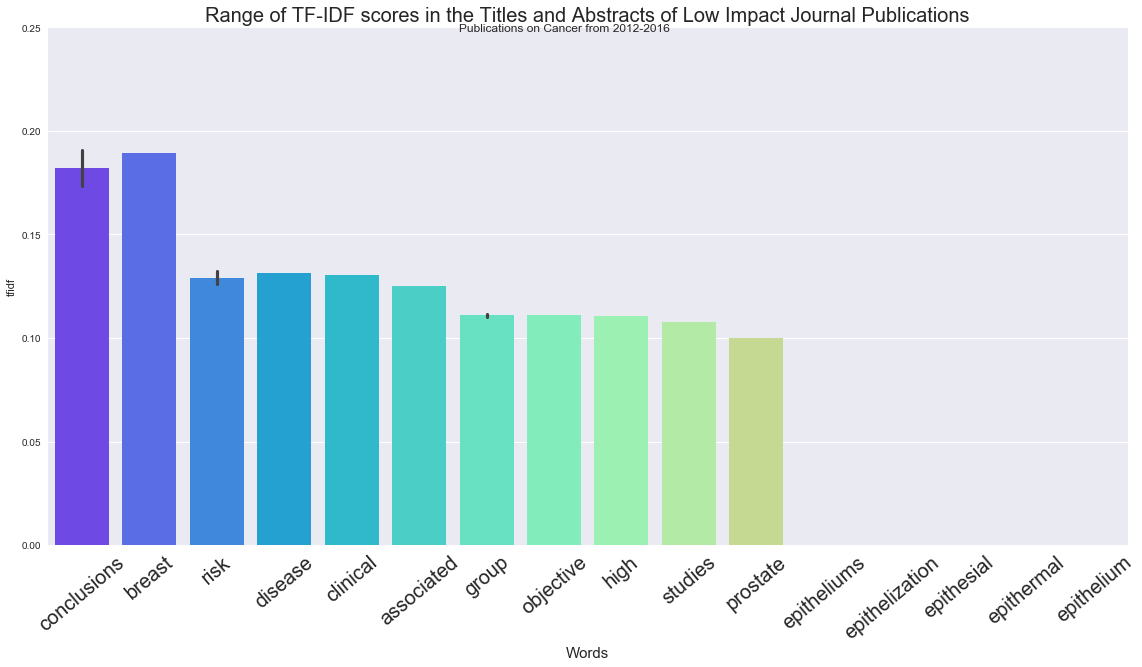

In [89]:
colors=cm.rainbow(np.random.rand(15))

g = sns.factorplot( x= "Word", y= 'tfidf', 
                   data=df_groupslow_tfidf, kind="bar", palette = 'rainbow', size= 8, aspect= 2)

plt.xlabel("Words", fontsize= 15)
plt.title('Range of TF-IDF scores in the Titles and Abstracts of Low Impact Journal Publications', fontsize= 20)
plt.suptitle('Publications on Cancer from 2012-2016', fontsize= 12)
plt.xticks(rotation=40, fontsize= 20)
plt.ylim(ymax= 0.25)
plt.show()

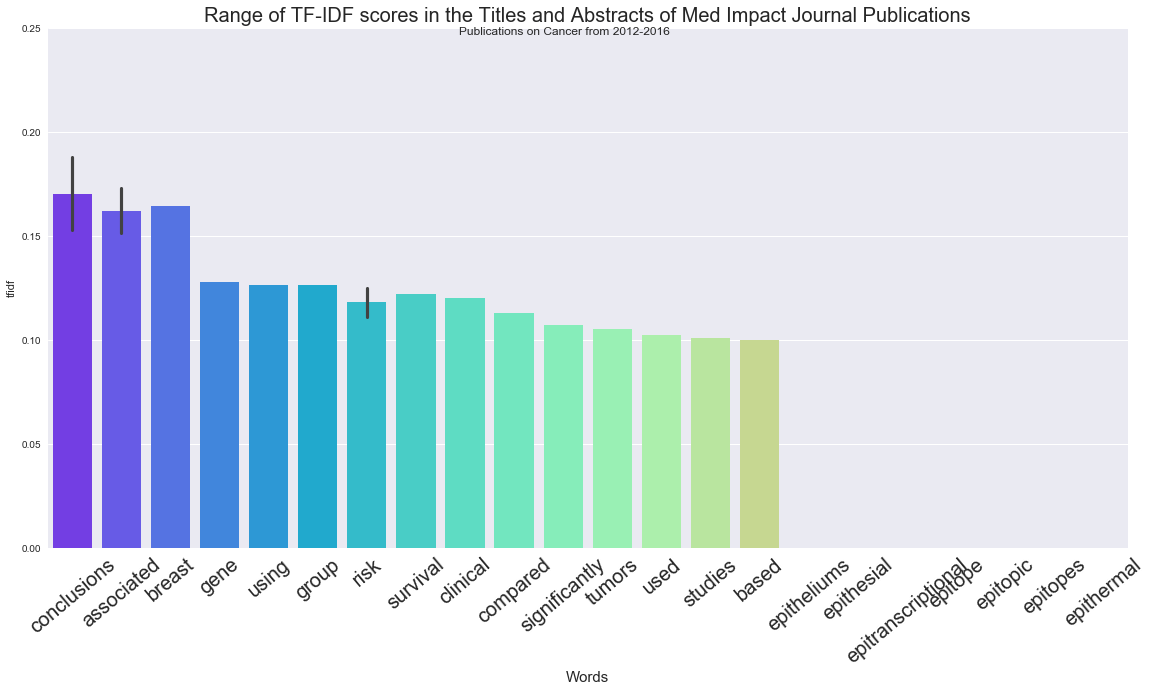

In [92]:
g = sns.factorplot( x= "Word", y= 'tfidf', 
                   data=df_groupsmed_tfidf, kind="bar", palette = 'rainbow', size= 8, aspect= 2)

plt.xlabel("Words", fontsize= 15)
plt.title('Range of TF-IDF scores in the Titles and Abstracts of Med Impact Journal Publications', fontsize= 20)
plt.suptitle('Publications on Cancer from 2012-2016', fontsize= 12)
plt.xticks(rotation=40, fontsize= 20)
plt.ylim(ymax= 0.25)
plt.show()

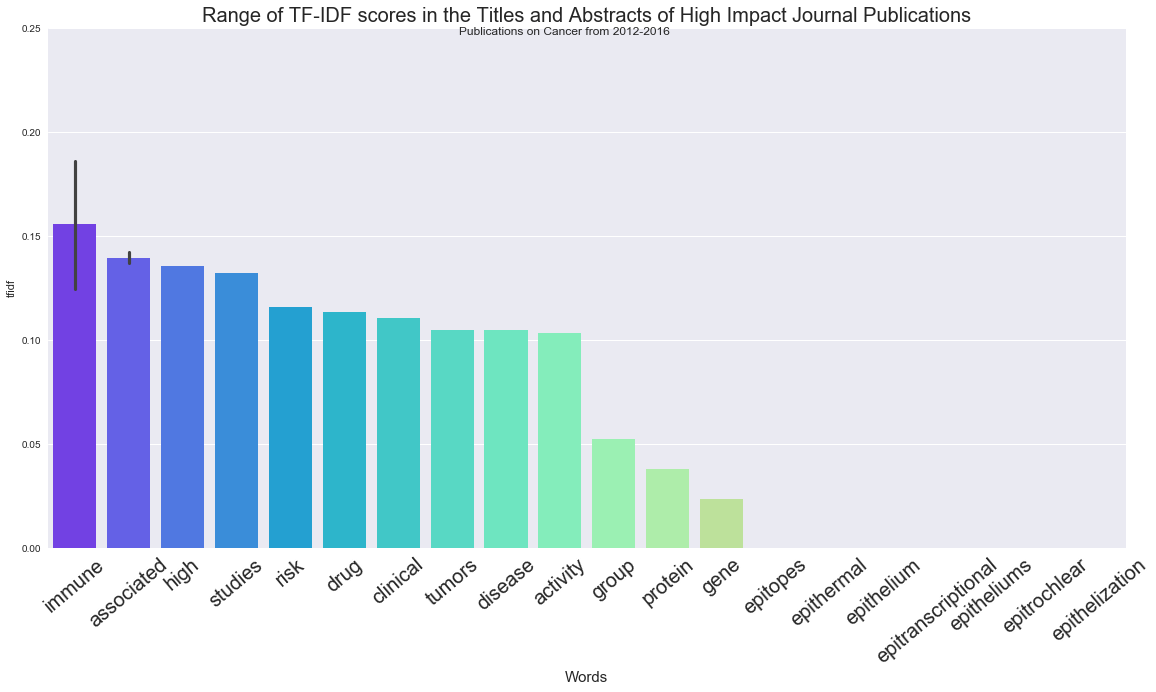

In [90]:
g = sns.factorplot( x= "Word", y= 'tfidf', 
                   data=df_groupshigh_tfidf, kind="bar", palette = 'rainbow', size= 8, aspect= 2)
plt.xlabel("Words", fontsize= 15)
plt.title('Range of TF-IDF scores in the Titles and Abstracts of High Impact Journal Publications', fontsize= 20)
plt.suptitle('Publications on Cancer from 2012-2016', fontsize= 12)
plt.xticks(rotation=40, fontsize= 20)
plt.ylim(ymax= 0.25)

plt.show()

In [95]:


group_high = [tfidf_12_high.sort_values('tfidf', ascending= False)[::5],  
            tfidf_13_high.sort_values('tfidf', ascending= False)[::5],
            tfidf_14_high.sort_values('tfidf', ascending= False)[::5],
            tfidf_15_high.sort_values('tfidf', ascending= False)[::5],
            tfidf_16_high.sort_values('tfidf', ascending= False)[::5]]
df_groupshigh_tfidf = pd.concat(group_high)


In [123]:
group_all = [tfidf_12_high.sort_values('tfidf', ascending= False)[::5],
             tfidf_12_med.sort_values('tfidf', ascending= False)[::5],
             tfidf_12_low.sort_values('tfidf', ascending= False)[::5],
             tfidf_13_high.sort_values('tfidf', ascending= False)[::5],
             tfidf_13_med.sort_values('tfidf', ascending= False)[::5],
             tfidf_13_low.sort_values('tfidf', ascending= False)[::5],
            tfidf_14_high.sort_values('tfidf', ascending= False)[::5],
             tfidf_14_med.sort_values('tfidf', ascending= False)[::5],
             tfidf_14_low.sort_values('tfidf', ascending= False)[::5],
             tfidf_15_high.sort_values('tfidf', ascending= False)[::5],
             tfidf_15_med.sort_values('tfidf', ascending= False)[::5],
             tfidf_15_low.sort_values('tfidf', ascending= False)[::5],
            tfidf_16_high.sort_values('tfidf', ascending= False)[::5],
             tfidf_16_med.sort_values('tfidf', ascending= False)[::5],
             tfidf_16_low.sort_values('tfidf', ascending= False)[::5]]
df_groups_tfidf_sorted = pd.concat(group_all)

In [125]:
group_all = [tfidf_12_high.sort_values('tfidf', ascending= False)[::5],
             tfidf_12_low.sort_values('tfidf', ascending= False)[::5],
             tfidf_13_high.sort_values('tfidf', ascending= False)[::5],
             tfidf_13_low.sort_values('tfidf', ascending= False)[::5],
            tfidf_14_high.sort_values('tfidf', ascending= False)[::5],
             tfidf_14_low.sort_values('tfidf', ascending= False)[::5],
             tfidf_15_high.sort_values('tfidf', ascending= False)[::5],
             tfidf_15_low.sort_values('tfidf', ascending= False)[::5],
            tfidf_16_high.sort_values('tfidf', ascending= False)[::5],
             tfidf_16_low.sort_values('tfidf', ascending= False)[::5]]
df_groups_tfidf_sorted_nomed = pd.concat(group_all)
df_groups_tfidf_sorted_nomed= df_groups_tfidf_sorted_nomed.sort_values('tfidf', ascending=False)

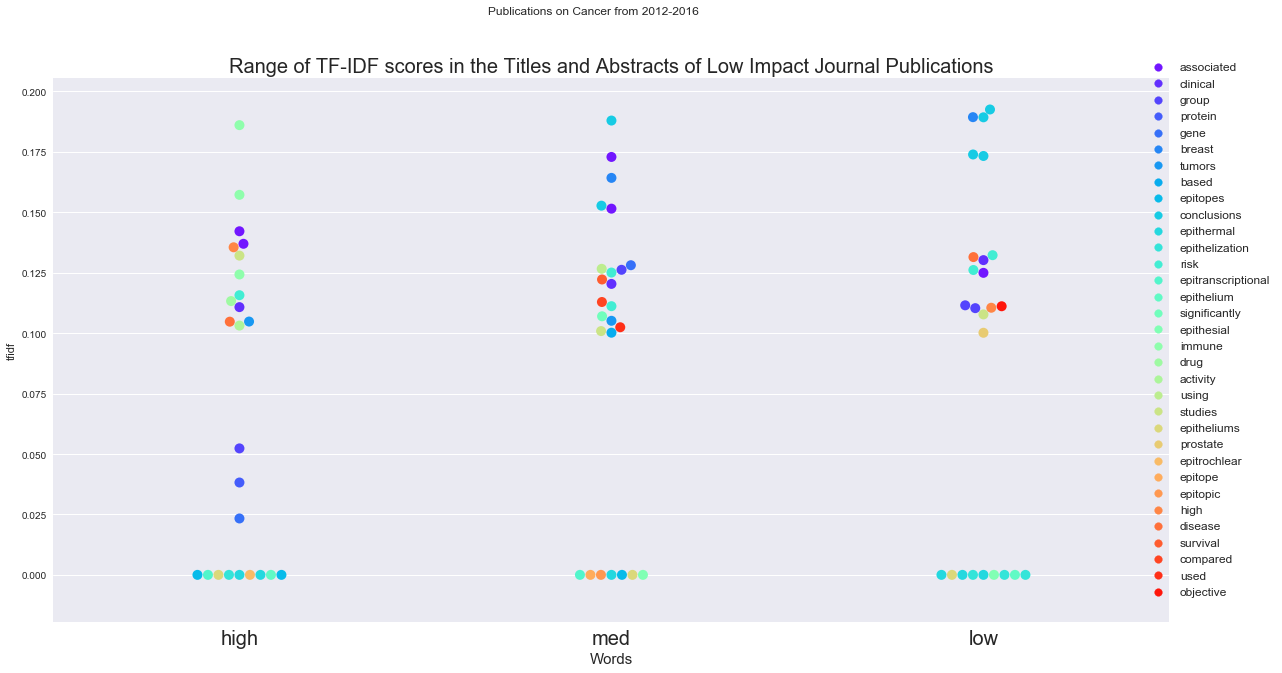

In [126]:
colors=cm.rainbow(np.random.rand(15))
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 20
fig_size[1] = 10

g = sns.swarmplot( x= "IF_score_group", y= 'tfidf', hue= 'Word', size= 10, edgecolor= 'black',
                   data=df_groups_tfidf_sorted, palette = 'rainbow')
plt.xlabel("Words", fontsize= 15)
plt.title('Range of TF-IDF scores in the Titles and Abstracts of Low Impact Journal Publications', fontsize= 20)
plt.suptitle('Publications on Cancer from 2012-2016', fontsize= 12)
plt.xticks(rotation=0, fontsize= 20)
plt.legend(bbox_to_anchor=(1.1, 1.05), fontsize= 12)
plt.show()

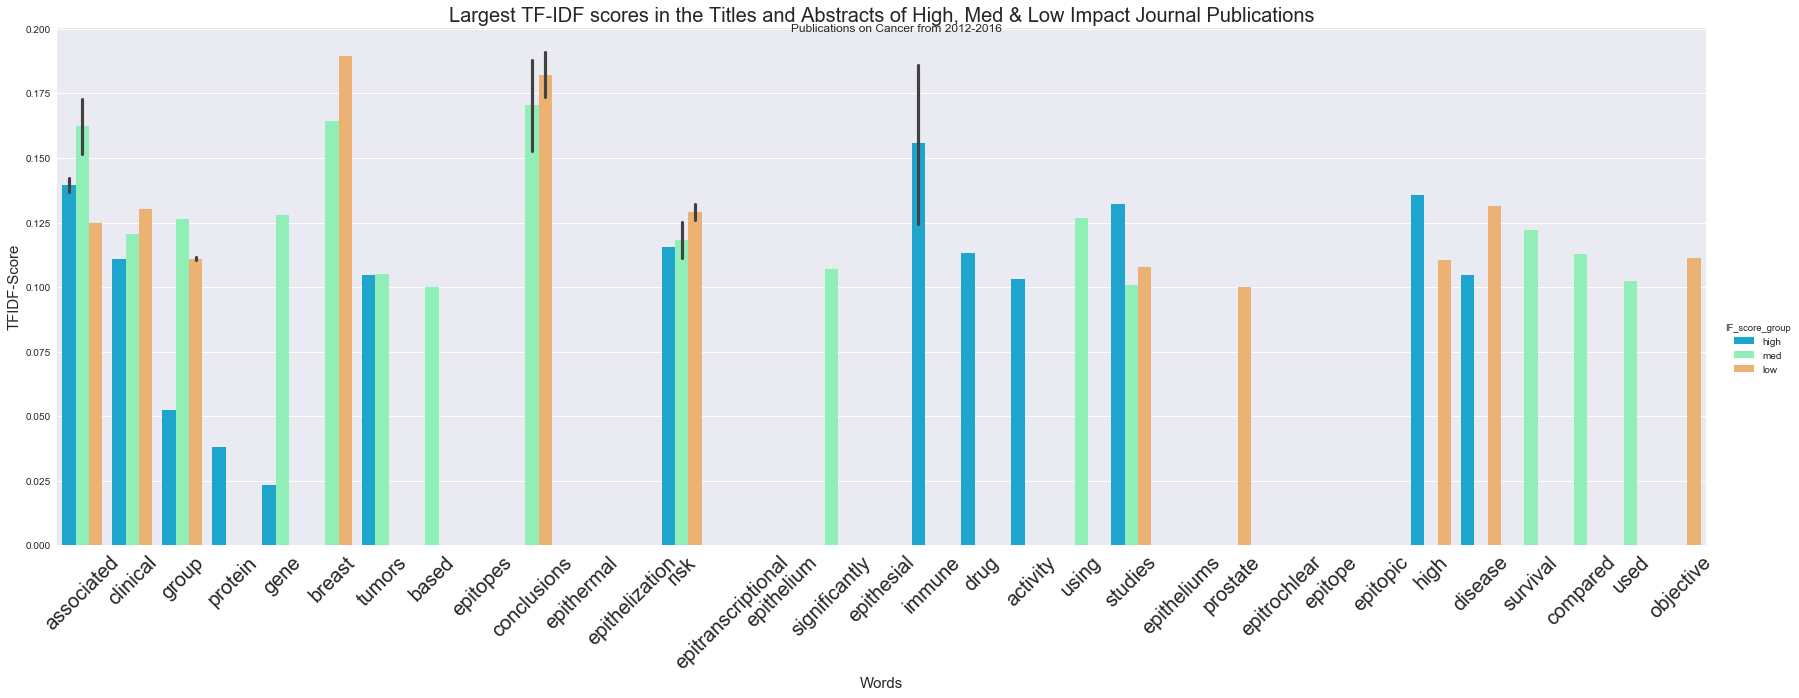

In [127]:
colors=cm.rainbow(np.random.rand(15))


g = sns.factorplot( x= "Word", y= 'tfidf', hue= 'IF_score_group', 
                   data=df_groups_tfidf_sorted, kind="bar", palette = 'rainbow', size= 8, aspect= 3)
plt.xlabel("Words", fontsize= 15)
plt.ylabel("TFIDF-Score", fontsize= 15)
plt.title('Largest TF-IDF scores in the Titles and Abstracts of High, Med & Low Impact Journal Publications', fontsize= 20)
plt.suptitle('Publications on Cancer from 2012-2016', fontsize= 12)
plt.xticks(rotation=45, fontsize= 20)

plt.show()

# Topic Modeling (using NMF)
year- to-year
group-to-group
Extracting Stop Words identified above.

In [169]:
import os

group_all = [tfidf_12_high, tfidf_12_med, tfidf_12_low, tfidf_13_high, tfidf_13_med, tfidf_13_low,
            tfidf_14_high, tfidf_14_med, tfidf_14_low, tfidf_15_high, tfidf_15_med, tfidf_15_low,
            tfidf_16_high, tfidf_16_med, tfidf_16_low]
df_groups_tfidf = pd.concat(group_all)

full_list= ( 
        df_tiabs_12h, df_tiabs_12m, df_tiabs_12l,
        df_tiabs_13h, df_tiabs_13m, df_tiabs_13l,
        df_tiabs_14h, df_tiabs_14m, df_tiabs_14l,
        df_tiabs_15h, df_tiabs_15m, df_tiabs_15l,
        df_tiabs_16h, df_tiabs_16m, df_tiabs_16l)


In [174]:
no_topics = 20

In [175]:
# using this source (for my notes) https://medium.com/mlreview/topic-modeling-with-scikit-learn-e80d33668730
from sklearn.decomposition import NMF, LatentDirichletAllocation
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

no_features= 1000

tfidf_vectorizer = TfidfVectorizer(max_df= 0.95, min_df= 2, max_features= no_features, stop_words = stop_words)
tfidf = tfidf_vectorizer.fit_transform(full_list)
tfidf_feature_names = tfidf_vectorizer.get_feature_names()

# LDA can only use raw term counts for LDA because it is a probailistic graphic model
tf_vectorizer = CountVectorizer(max_df=0.95, min_df=2, max_features= no_features,
                               stop_words= stop_words)
tf= tf_vectorizer.fit_transform(full_list)
tf_feature_names = tf_vectorizer.get_feature_names()


In [176]:
# Run LDA
lda = LatentDirichletAllocation(n_topics=no_topics, max_iter=5, learning_method='online', 
                                learning_offset=50.,random_state=0).fit(tf)


In [178]:
def display_topics(model, feature_names, no_top_words):
    topic_list= []
    for topic_idx, topic in enumerate(model.components_):
        print( "Topic:", topic_idx)

        print (" ".join([feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]]))
        temp_list = [(feature_names[i]) for i in topic.argsort()[:-no_top_words - 1:-1]]
        topic_list.append((temp_list, topic_idx))
    df = pd.DataFrame(topic_list)
    df.columns = ['topic_words', 'groups']
    return df

In [179]:
no_top_words= 10

In [180]:
df_topic_words= display_topics(lda, tf_feature_names, no_top_words)

Topic: 0
os u200a biopsy cisplatin right xa00 procedure set classification tests
Topic: 1
os biopsy xa00 operative cisplatin objectives classification bc right laparoscopic
Topic: 2
biopsy os preoperative retrospectively polymorphism tumours xa00 pfs 2011 january
Topic: 3
os biopsy xa00 esophageal tumours laparoscopic retrospectively procedure preoperative cisplatin
Topic: 4
os right preoperative biopsy tumours xa00 cisplatin retrospectively operative 2011
Topic: 5
u200a os cisplatin esophageal xa00 biopsy u200a0 right pfs retrospectively
Topic: 6
biopsy laparoscopic xa00 right os preoperative 2011 reconstruction classification esophageal
Topic: 7
os u200a biopsy esophageal cisplatin xa00 classification preoperative u200a0 right
Topic: 8
u200a os u200a0 esophageal biopsy pfs cisplatin recurrent right emt
Topic: 9
os l1 biopsy mr pfs cisplatin classification car xa00 dc
Topic: 10
os biopsy xa00 right preoperative procedure cisplatin laparoscopic esophageal operative
Topic: 11
u200a u200

In [ ]:
# Importing Gensim
import gensim
from gensim import corpora
t
# Creating the term dictionary of our courpus, where every unique term is assigned an index. dictionary = corpora.Dictionary(doc_clean)
dictionary = corpora.Dictionary(texts)
dictionary.save('dictionary.dict')

In [ ]:
doc_term_matrix = [dictionary.doc2bow(doc) for doc in texts]
corpora.MmCorpus.serialize('corpus.mm', doc_term_matrix)

In [ ]:
# Creating the object for LDA model using gensim library
Lda = gensim.models.ldamodel.LdaModel

# Running and Trainign LDA model on the document term matrix.
ldamodel = Lda(doc_term_matrix, num_topics=10, id2word = dictionary, passes=50)

In [194]:
full_list= (df_tiabs_high, df_tiabs_med, df_tiabs_low)

In [196]:
from nltk.corpus import stopwords 
from nltk.stem.wordnet import WordNetLemmatizer
import string

exclude = set(string.punctuation) 
lemma = WordNetLemmatizer()
def clean(doc):
    stop_free = " ".join([i for i in doc.lower().split() if i not in stop_words])
    punc_free = ''.join(ch for ch in stop_free if ch not in exclude)
    normalized = " ".join(lemma.lemmatize(word) for word in punc_free.split())
    return normalized

doc_clean = [clean(doc).split() for doc in full_list]    

In [197]:
import gensim
from gensim import corpora

# Creating the term dictionary of our courpus, where every unique term is assigned an index. dictionary = corpora.Dictionary(doc_clean)
dictionary = corpora.Dictionary(doc_clean)
# Converting list of documents (corpus) into Document Term Matrix using dictionary prepared above.
doc_term_matrix = [dictionary.doc2bow(doc) for doc in doc_clean]

In [198]:
Lda = gensim.models.ldamodel.LdaModel

# Running and Trainign LDA model on the document term matrix.
ldamodel = Lda(doc_term_matrix, num_topics=15, id2word = dictionary, passes=50)

In [199]:
print(ldamodel.print_topics(num_topics=3, num_words=5))

[(2, '0.010*"attributeslabel" + 0.009*"nlmcategory" + 0.005*"method" + 0.005*"conclusion" + 0.005*"result"'), (1, '0.000*"nlmcategory" + 0.000*"attributeslabel" + 0.000*"conclusion" + 0.000*"cancer" + 0.000*"method"'), (10, '0.000*"attributeslabel" + 0.000*"nlmcategory" + 0.000*"result" + 0.000*"cancer" + 0.000*"method"')]


In [201]:
 K = ldamodel.num_topics

In [202]:
topicWordProbMat= ldamodel.print_topics(K)

In [203]:
topicWordProbMat

[(0,
  '0.000*"attributeslabel" + 0.000*"conclusion" + 0.000*"nlmcategory" + 0.000*"method" + 0.000*"cancer" + 0.000*"result" + 0.000*"study" + 0.000*"level" + 0.000*"survival" + 0.000*"using"'),
 (1,
  '0.000*"nlmcategory" + 0.000*"attributeslabel" + 0.000*"conclusion" + 0.000*"cancer" + 0.000*"method" + 0.000*"result" + 0.000*"patient" + 0.000*"study" + 0.000*"effect" + 0.000*"breast"'),
 (2,
  '0.010*"attributeslabel" + 0.009*"nlmcategory" + 0.005*"method" + 0.005*"conclusion" + 0.005*"result" + 0.005*"cancer" + 0.004*"gene" + 0.004*"study" + 0.004*"level" + 0.004*"protein"'),
 (3,
  '0.011*"attributeslabel" + 0.011*"nlmcategory" + 0.006*"method" + 0.006*"conclusion" + 0.006*"result" + 0.005*"cancer" + 0.004*"breast" + 0.004*"group" + 0.004*"disease" + 0.004*"study"'),
 (4,
  '0.006*"attributeslabel" + 0.006*"nlmcategory" + 0.005*"cancer" + 0.004*"cell" + 0.004*"study" + 0.004*"method" + 0.003*"result" + 0.003*"conclusion" + 0.003*"disease" + 0.003*"effect"'),
 (5,
  '0.000*"nlmcate

# Frequency w/ stop words


In [99]:
# addingmost frequent words from all data in paper titles and abstracts as stop words 
from sklearn.feature_extraction import text 

# most common words from earlier TF- analysis from both All-Titles list and All-Abstracts list 
titles_common= ('cell', 'patients','patient','stringelement', 'cells', 'study','expression', 'tumor', 'human', 
                 'treatment', 'therapy', 'case','analysis', 'review', 
                'patients', '%', 'label', 'nlmcategory', '}', 'cells', 'cell', 'results', 'cancer', 'attributes')
stop_words = text.ENGLISH_STOP_WORDS.union(titles_common)

In [104]:
# define function to identify and create a simple DF of top N words from a column of the DF
# As 'Cancer' was a defined keyword (either in title or abstract or topics) for all the papers
# I will add it to the stopwords list now, to keep it from throwing off results
# define functino to identify and create a simple DF of top N words from a column of the DF
def word_freq_update(df, column, top_N):
    txt = df[column].str.lower().str.replace(r'\|', ' ').str.cat(sep=' ')
    words = nltk.tokenize.word_tokenize(txt)
    stoppunc = ['.', ',', ':', '(', ')', '?', '!', '[', ']', 'cancer', 'Cancer']
    word_dist = nltk.FreqDist(words)

    stopwords = stop_words
    words_except_stop_dist = nltk.FreqDist(w for w in words if w not in stopwords if w not in stoppunc) 

    rslt = pd.DataFrame(words_except_stop_dist.most_common(top_N),
                    columns=['Word', 'Frequency']).set_index('Word')
    word_freq_update.rslt = rslt


In [105]:
# run function on each DF w/'Paper Title' and N=15, save each result
# Given that not all lists will overlap I am cutting the N so the Graph will be more readable
word_freq_update(df_ifj_high,'Paper Title', 50)
rslt_all_highifj = word_freq_update.rslt

word_freq_update(df_ifj_med,'Paper Title',50)
rslt_all_medifj = word_freq_update.rslt

word_freq_update(df_ifj_low,'Paper Title',50)
rslt_all_lowifj = word_freq_update.rslt

In [106]:
lowifj_= rslt_all_lowifj.assign(JIF_group= 'low')
medifj_= rslt_all_medifj.assign(JIF_group= 'med')
highifj_= rslt_all_highifj.assign(JIF_group= 'high')
allifj_=pd.concat((lowifj_, medifj_, highifj_))
allifj_= allifj_.reset_index()
allifj_.head(3)

,Word,Frequency,JIF_group
0,breast,962,low
1,carcinoma,839,low
2,lung,597,low


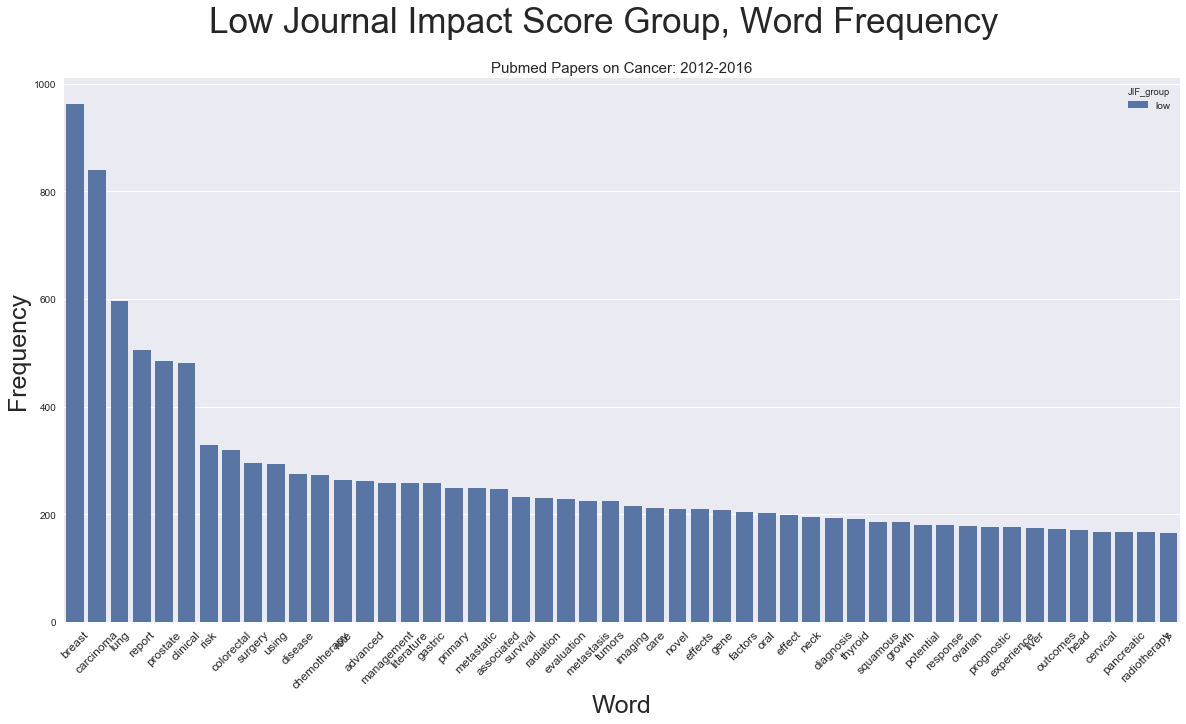

In [288]:
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 20
fig_size[1] = 10

sns.barplot(data= lowifj_, x= lowifj_.index, y='Frequency', hue='JIF_group')
plt.title('Pubmed Papers on Cancer: 2012-2016', fontsize= 15)
plt.suptitle('Low Journal Impact Score Group, Word Frequency', fontsize= 35)
plt.xticks( rotation= 45, fontsize= 12)
plt.xlabel('Word', fontsize=25)
plt.ylabel('Frequency', fontsize= 25)
plt.show()

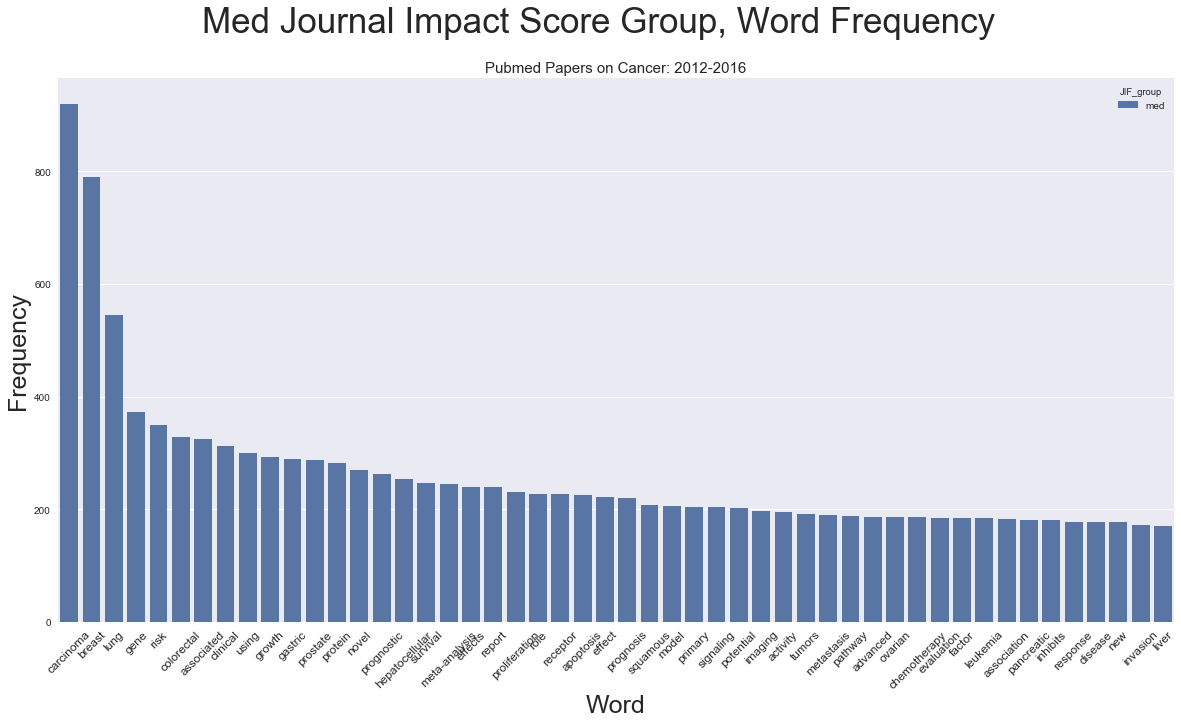

In [287]:
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 20
fig_size[1] = 10

sns.barplot(data= medifj_, x= medifj_.index, y='Frequency', hue='JIF_group')
plt.title('Pubmed Papers on Cancer: 2012-2016', fontsize= 15)
plt.suptitle('Med Journal Impact Score Group, Word Frequency', fontsize= 35)
plt.xticks( rotation= 45, fontsize= 12)
plt.xlabel('Word', fontsize=25)
plt.ylabel('Frequency', fontsize= 25)
plt.show()

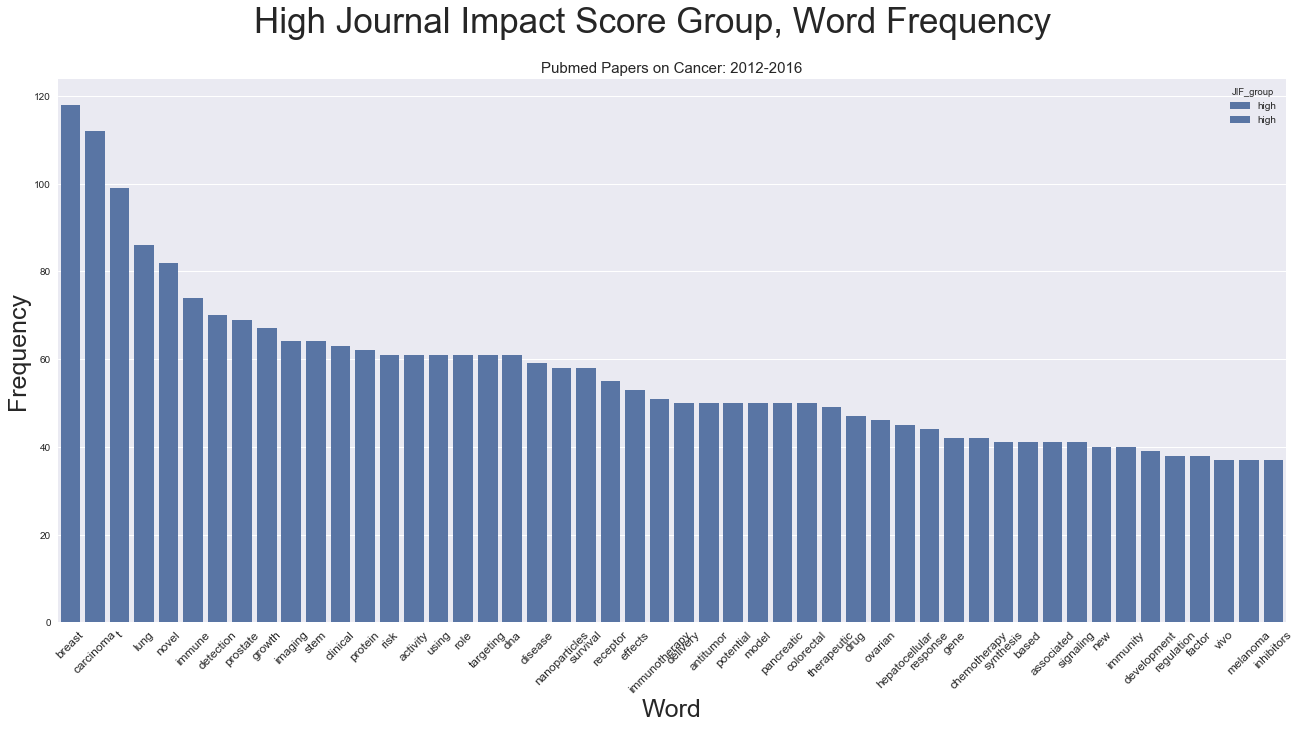

In [284]:
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 22
fig_size[1] = 10

sns.barplot(data=highifj_, x= highifj_.index, y='Frequency', hue='JIF_group')
plt.title('Pubmed Papers on Cancer: 2012-2016', fontsize= 15)
plt.suptitle('High Journal Impact Score Group, Word Frequency', fontsize= 35)
plt.xticks( rotation= 45, fontsize= 12)
plt.xlabel('Word', fontsize=25)
plt.ylabel('Frequency', fontsize= 25)
plt.show()

In [311]:
allifj_.head(4)

,Word,Frequency,JIF_group
0,breast,962,low
1,carcinoma,839,low
2,lung,597,low
3,report,506,low


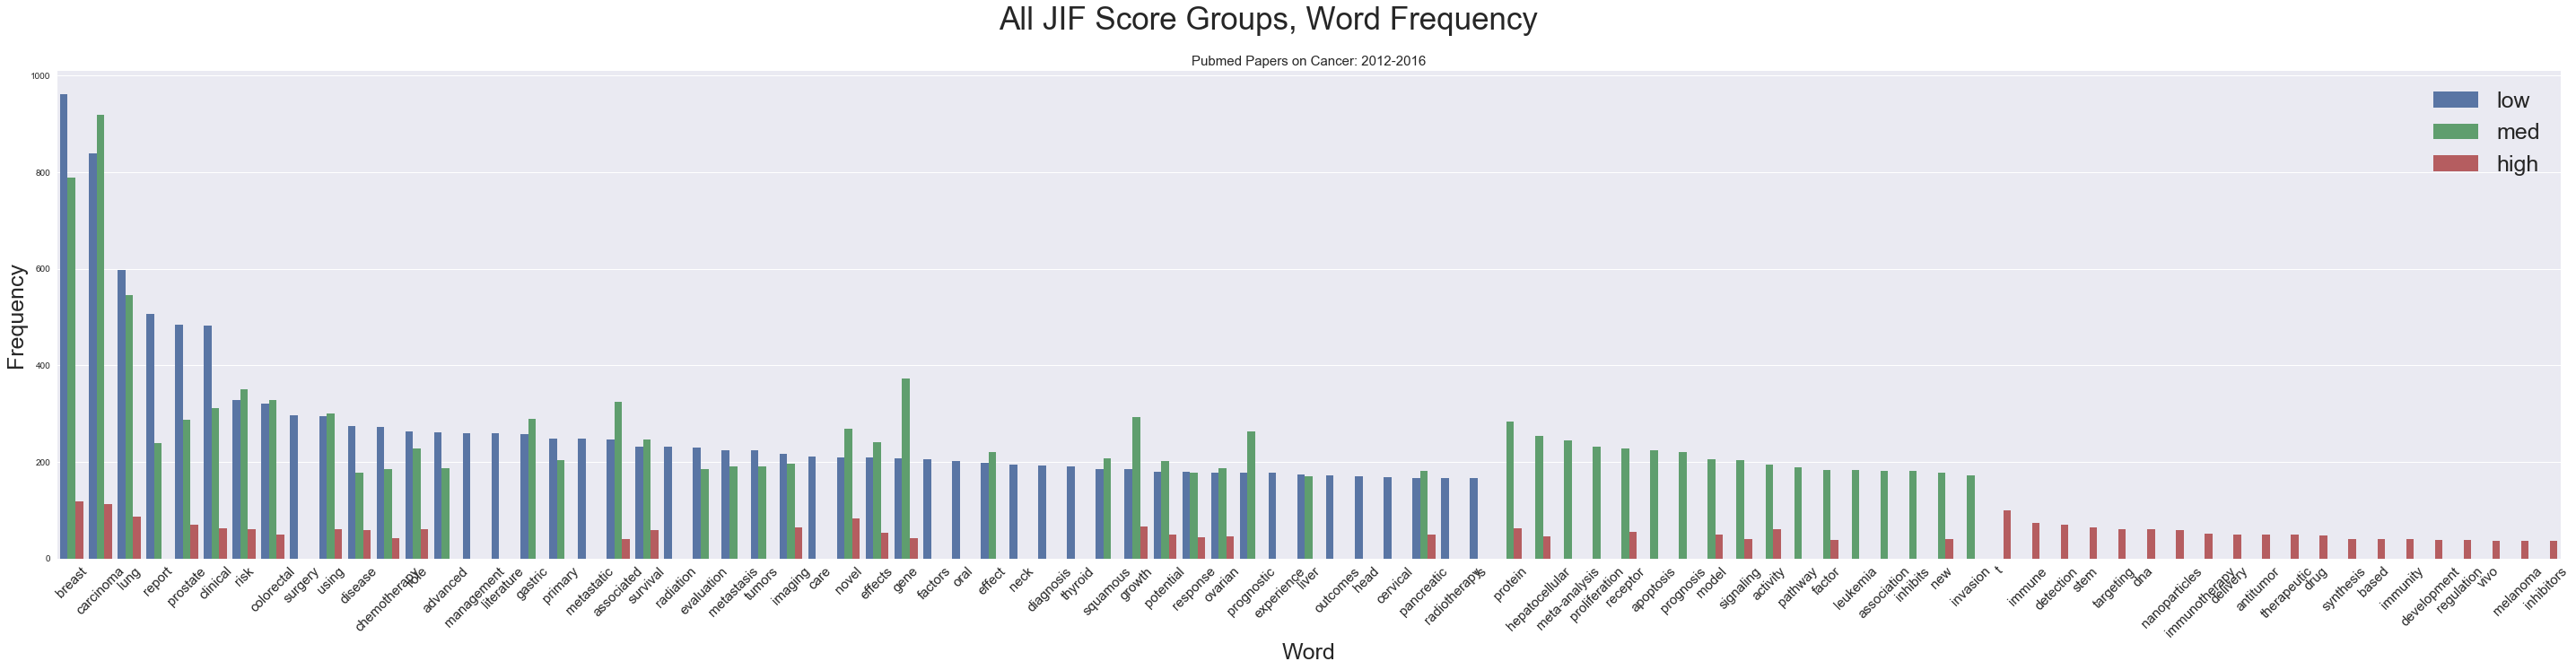

In [310]:
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 50
fig_size[1] = 10

sns.barplot(data=allifj_, x=allifj_['Word'], y=allifj_['Frequency'], hue=allifj_['JIF_group'])
plt.title('Pubmed Papers on Cancer: 2012-2016', fontsize= 15)
plt.suptitle('All JIF Score Groups, Word Frequency', fontsize= 35)
plt.xticks( rotation= 45, fontsize= 15)
plt.xlabel('Word', fontsize=25)
plt.legend(loc='upper right', fontsize= 25)
plt.ylabel('Frequency', fontsize= 25)
plt.show()

In [297]:
#identified words with interesting patterns and words specific to certain kinds of cancer found int he top 50 most frequent in all lists
# graph the frequency of those words in all three lists
cancer_types= ('breast','carcinoma','lung','prostate','colorectal','gastric',
              'oral','thyroid','ovarian', 'squamous', 'cervical','liver', 'pancreatic','hepatocellular',
              'leukemia','melanoma')
random_interest_words=('primary','metastatic','advanced')

In [111]:
cancer_counts_all= allifj_[allifj_['Word'].isin(cancer_types)]

In [112]:
random_counts_al= allifj_[allifj_['Word'].isin(random_interest_words)]

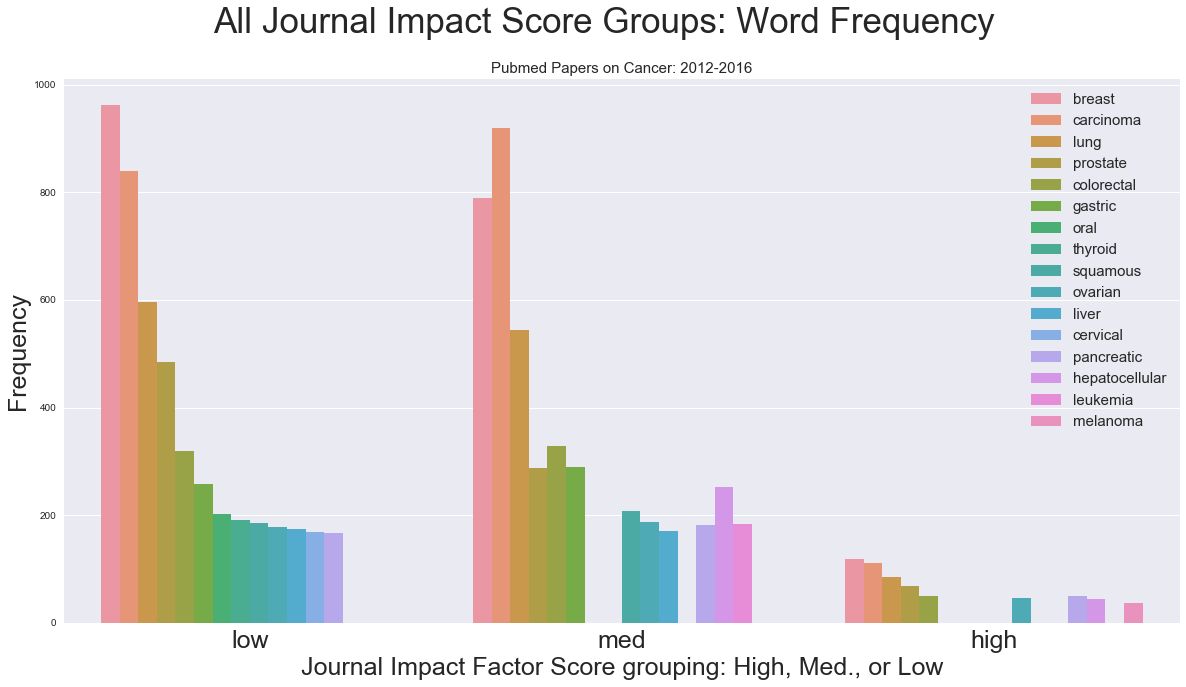

In [113]:
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 20
fig_size[1] = 10

sns.barplot(data=cancer_counts_all, x= 'JIF_group', y='Frequency', hue='Word')
plt.title('Pubmed Papers on Cancer: 2012-2016', fontsize= 15)
plt.suptitle('All Journal Impact Score Groups: Word Frequency', fontsize= 35)
plt.xticks( fontsize= 25)
plt.xlabel('Journal Impact Factor Score grouping: High, Med., or Low', fontsize=25)
plt.ylabel('Frequency', fontsize=25)
plt.legend(fontsize=15)
plt.show()

In [114]:
cancer_counts_all.head(3)

,Word,Frequency,JIF_group
0,breast,962,low
1,carcinoma,839,low
2,lung,597,low


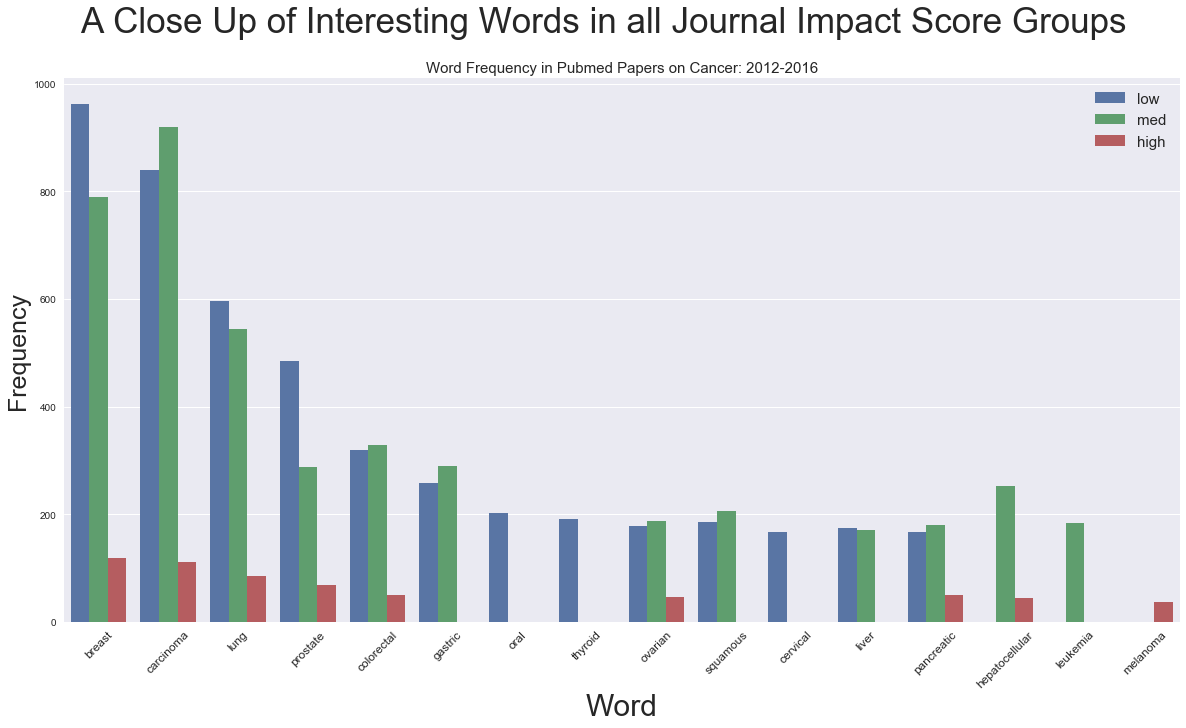

In [233]:
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 20
fig_size[1] = 10
X= cancer_counts_all.count()

sns.barplot(data=cancer_counts_all, x= cancer_counts_all['Word'], y='Frequency', hue='JIF_group', order=cancer_types)
plt.title('Word Frequency in Pubmed Papers on Cancer: 2012-2016', fontsize= 15)
plt.suptitle('A Close Up of Interesting Words in all Journal Impact Score Groups', fontsize= 35)
plt.xticks(rotation= 45, fontsize= 12)
plt.xlabel('Word', fontsize=30)
plt.ylabel('Frequency', fontsize=25)
plt.legend(loc='upper right', fontsize= 15)
plt.show()

In [365]:

df_cancer_rates =pd.read_csv('C:/Users/Esme/Desktop/Springboard/Capstone_1/Age standerdized cancer rates.csv', index_col = 0, header= 1, sep=",", engine = 'python', na_filter = False)

In [369]:
df_cancer_rates

,WORLD,More Developed,Less Developed
Cancer,,,
Lung,23.1,30.8,20.0
Colorectum,17.2,29.2,11.7
Stomach,12.1,10.6,12.7
Liver,10.1,5.4,12.0
Oesophagus,5.9,3.6,7.0
Bladder,5.3,9.5,3.3
Non-Hodgkin lymphoma,5.0,8.6,3.6
Leukaemia,4.7,7.2,3.8
Kidney,4.4,9.2,2.6
